In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from swmm_api import read_out_file
import os
from matplotlib.gridspec import GridSpec

In [2]:
from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 12,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['Times New Roman'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

In [3]:
rainid = np.load('./step0-knowledge/rainfall/testRainID.npy',allow_pickle=True).tolist()
print(rainid)

[10, 20, 30, 40, 50, 55, 60, 65, 70, 80]


# Load results files

In [4]:
results_BC, results_EFD, results_OPT = {}, {}, {}
results_PPO, results_PPO_pre, results_PPO_KG = {}, {}, {}
results_DQN, results_DQN_pre, results_DQN_KG = {}, {}, {}
results_DQN_nosafe, results_PPO_nosafe = {}, {}

for i in rainid:
    results_BC['rain'+str(i)] = np.load('./step0-knowledge/BC_results/bc_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()
    results_EFD['rain'+str(i)] = np.load('./step0-knowledge/EFD_results/efd_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()
    results_OPT['rain'+str(i)] = np.load('./step0-knowledge/OPT_results/opt_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()

    results_PPO['rain'+str(i)] = np.load('./step3-DRL fullnosafe/results/ppo_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()
    results_PPO_pre['rain'+str(i)] = np.load('./step1-DRL pretrain/results/ppo_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()
    results_PPO_KG['rain'+str(i)] = np.load('./step2-DRL finetune/results/ppo_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()
    #results_PPO_nosafe['rain'+str(i)] = np.load('./step3-DRL fullnosafe/results/ppo_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()
    
    results_DQN['rain'+str(i)] = np.load('./step3-DRL fullnosafe/results/dqn_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()
    results_DQN_pre['rain'+str(i)] = np.load('./step1-DRL pretrain/results/dqn_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()
    results_DQN_KG['rain'+str(i)] = np.load('./step2-DRL finetune/results/dqn_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()
    #results_DQN_nosafe['rain'+str(i)] = np.load('./step3-DRL fullnosafe/results/dqn_results_rain'+str(i)+'.npy',allow_pickle=True).tolist()

## 统计调整orifice次数

In [5]:
def count(data):
    con = 0
    for i in range(1,data.shape[0]):
        if data[i]!=data[i-1]:
            con += 1
    return con

In [9]:
def sum_count_PPO(rid):
    BCcon,EFDcon,OPTcon = 6,6,6
    PPOcon,PPOprecon,PPOKGcon = 6,6,6
    for k in range(6):
        BCcon+=count(np.array(results_BC['rain'+rid]['action'])[:,k])
        EFDcon+=count(np.array(results_EFD['rain'+rid]['action'])[:,k])
        OPTcon+=count(np.array(results_OPT['rain'+rid]['action'])[:,k])

        PPOcon+=count(np.array(results_PPO['rain'+rid]['action'])[:,k])
        PPOprecon+=count(np.array(results_PPO_pre['rain'+rid]['action'])[:,k])
        PPOKGcon+=count(np.array(results_PPO_KG['rain'+rid]['action'])[:,k])
        
    #print(BCcon,EFDcon,OPTcon,DQNnosafecon,DQNcon,DQNprecon,DQNKGcon,PPOnosafecon,PPOcon,PPOprecon,PPOKGcon)
    return [BCcon,EFDcon,PPOcon,PPOprecon,PPOKGcon]

def sum_count_DQN(rid):
    BCcon,EFDcon,OPTcon = 6,6,6
    DQNcon,DQNprecon,DQNKGcon = 6,6,6
    for k in range(6):
        BCcon+=count(np.array(results_BC['rain'+rid]['action'])[:,k])
        EFDcon+=count(np.array(results_EFD['rain'+rid]['action'])[:,k])
        OPTcon+=count(np.array(results_OPT['rain'+rid]['action'])[:,k])

        DQNcon+=count(np.array(results_DQN['rain'+rid]['action'])[:,k])
        DQNprecon+=count(np.array(results_DQN_pre['rain'+rid]['action'])[:,k])
        DQNKGcon+=count(np.array(results_DQN_KG['rain'+rid]['action'])[:,k])

    #print(BCcon,EFDcon,OPTcon,DQNnosafecon,DQNcon,DQNprecon,DQNKGcon,PPOnosafecon,PPOcon,PPOprecon,PPOKGcon)
    return [BCcon,EFDcon,DQNcon,DQNprecon,DQNKGcon]

In [11]:
result = {}
for rid in rainid:
    result['Rain'+str(rid)]=sum_count_PPO(str(rid))

result = pd.DataFrame(result,index=['BC','EFD','PPO','Pre-PPO','KG-PPO'])
result.to_csv('table_fre_PPO.csv')
pd.DataFrame(result)


Rain10  Rain20  Rain30  Rain40  Rain50  Rain55  Rain60  Rain65  \
BC            6       6       6       6       6       6       6       6   
EFD          25      21      23      21      19      19      17      27   
PPO         196     225     213     214     208     225     201     227   
Pre-PPO       6       6       6       6       6       6       6       6   
KG-PPO       20      52      46      10      38      34      34      40   

         Rain70  Rain80  
BC            6       6  
EFD          25      21  
PPO         222     223  
Pre-PPO       6       6  
KG-PPO       32      44

In [12]:
result = {}
for rid in rainid:
    result['Rain'+str(rid)]=sum_count_DQN(str(rid))

result = pd.DataFrame(result,index=['BC','EFD','DQN','Pre-DQN','KG-DQN'])
result.to_csv('table_fre_DQN.csv')
pd.DataFrame(result)

Rain10  Rain20  Rain30  Rain40  Rain50  Rain55  Rain60  Rain65  \
BC            6       6       6       6       6       6       6       6   
EFD          25      21      23      21      19      19      17      27   
DQN          59      90      75      84      83      75      74      74   
Pre-DQN      14      34      26      24      30      36      30      24   
KG-DQN       28      26      30      24      50      48      42      30   

         Rain70  Rain80  
BC            6       6  
EFD          25      21  
DQN          58      83  
Pre-DQN      24      24  
KG-DQN       26      22

## Figure，所有降雨所有orifice的流量分别做图

## In paper

In [20]:
title_font = {'size':'18'}
title_font2 = {'size':'25'}

def fig(k,rid):
    
    fig = plt.figure(dpi=100,constrained_layout=True,
                 figsize=(15,10)
                )
                #constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
    gs = GridSpec(3, 2, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure

    ax00 = fig.add_subplot(gs[0, 0])
    ax00.plot(np.array(results_BC['rain'+rid]['action'])[:,k],label='BC')
    ax00.set_title('BC',fontdict=title_font2)
    ax00.set_xticks([0,95/2,95],[0,240,480])
    ax00.set_ylabel('Flow ('+'$m^{3}/s$'+')',fontdict=title_font)

    ax10 = fig.add_subplot(gs[1, 0])
    ax10.plot(np.array(results_EFD['rain'+rid]['action'])[:,k],label='EFD')
    ax10.set_title('EFD',fontdict=title_font2)
    ax10.set_xticks([0,95/2,95],[0,240,480])
    ax10.set_ylabel('Flow ('+'$m^{3}/s$'+')',fontdict=title_font)
    ax10.set_xlabel('Time (minutes)',fontdict=title_font)

    ax02 = fig.add_subplot(gs[0, 1])
    ax02.plot(np.array(results_PPO['rain'+rid]['action'])[:,k],label='PPO')
    ax02.set_title('PPO',fontdict=title_font2)
    ax02.set_xticks([0,95/2,95],[0,240,480])

    ax12 = fig.add_subplot(gs[1, 1])
    ax12.plot(np.array(results_PPO_pre['rain'+rid]['action'])[:,k],label='Pre-PPO')
    ax12.set_title('Pre-PPO',fontdict=title_font2)
    ax12.set_xticks([0,95/2,95],[0,240,480])

    ax22 = fig.add_subplot(gs[2, 1])
    ax22.plot(np.array(results_PPO_KG['rain'+rid]['action'])[:,k],label='KG-PPO')
    ax22.set_title('KG-PPO',fontdict=title_font2)
    ax22.set_xticks([0,95/2,95],[0,240,480])
    ax22.set_xlabel('Time (minutes)',fontdict=title_font)

    plt.savefig('./orfices'+'_'+str(k)+rid+'.png',dpi=200)

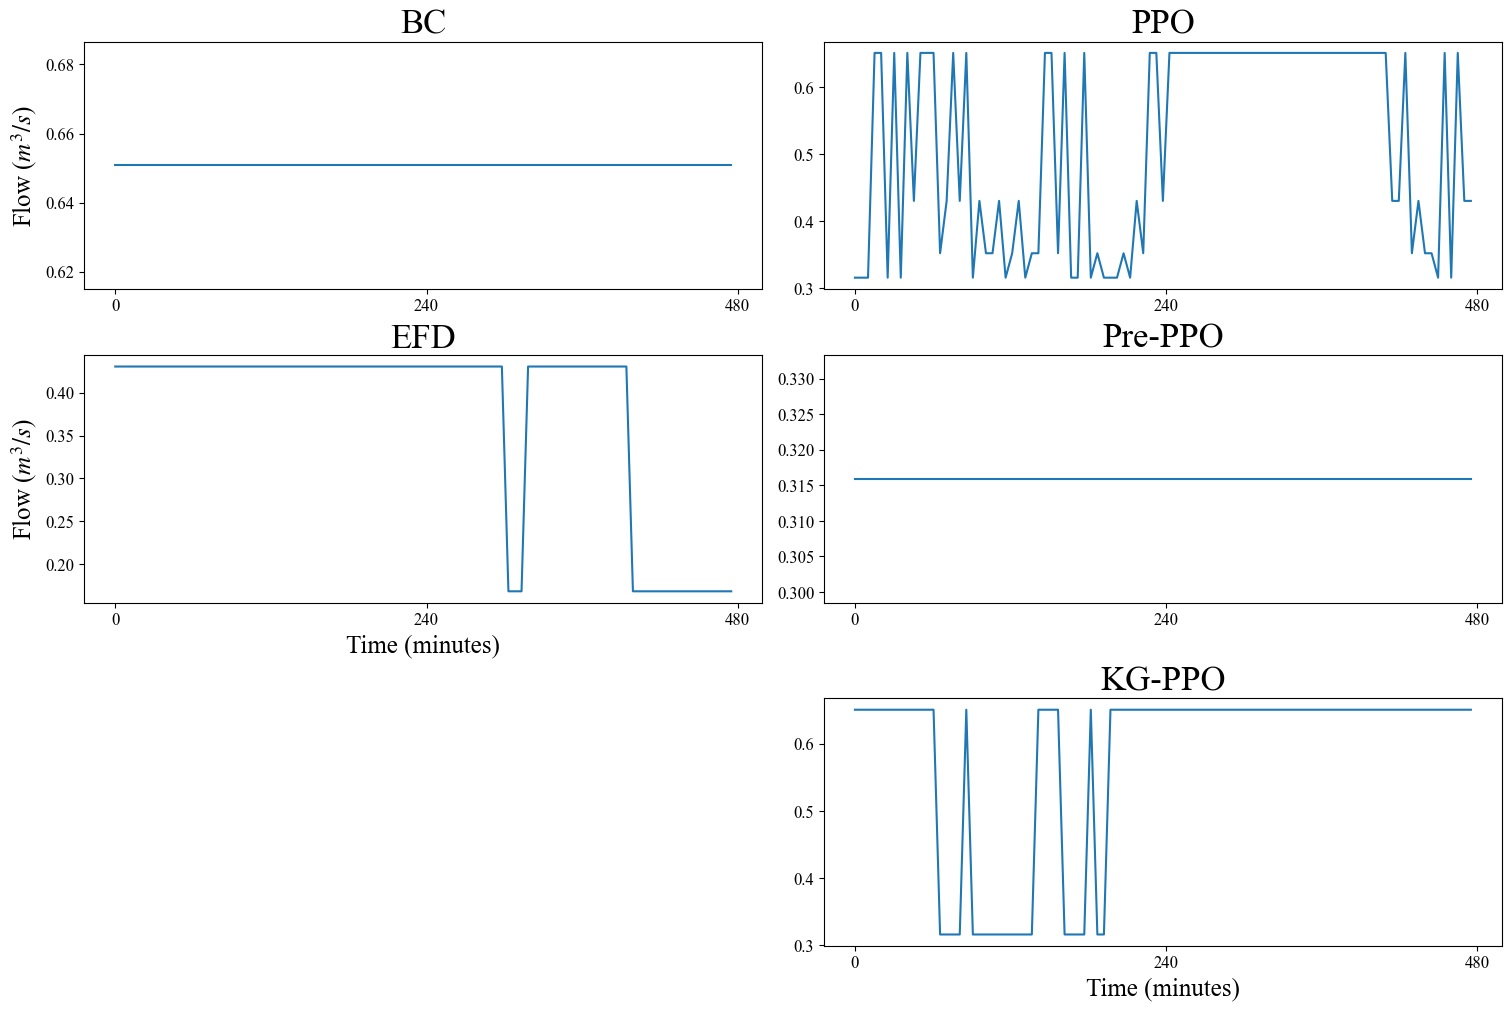

In [21]:
fig(2,str(rainid[1]))

In [ ]:
title_font = {'size':'18'}
title_font2 = {'size':'25'}

def fig(v,rid):
    
    fig = plt.figure(dpi=100,constrained_layout=True,
                 figsize=(15,10)
                )
                #constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
    gs = GridSpec(3, 3, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure

    ax00 = fig.add_subplot(gs[0, 0])
    ax00.plot(np.array(results_BC['rain'+rid]['action'])[:,k],label='BC')
    ax00.set_title('BC',fontdict=title_font2)
    ax00.set_xticks([0,95/2,95],[0,240,480])
    ax00.set_ylabel('Flow ('+'$m^{3}/s$'+')',fontdict=title_font)

    ax10 = fig.add_subplot(gs[1, 0])
    ax10.plot(np.array(results_EFD['rain'+rid]['action'])[:,k],label='EFD')
    ax10.set_title('EFD',fontdict=title_font2)
    ax10.set_xticks([0,95/2,95],[0,240,480])
    ax10.set_ylabel('Flow ('+'$m^{3}/s$'+')',fontdict=title_font)
    ax10.set_xlabel('Time (minutes)',fontdict=title_font)

    #ax20 = fig.add_subplot(gs[2, 0])
    #ax20.plot(np.array(results_OPT['rain'+rid]['action'])[:,k],label='OPT')
    #ax20.set_title('OPT',fontdict=title_font2)
    #ax20.set_xticks([0,95/2,95],[0,240,480])
    #ax20.set_xlabel('Time (min)',fontdict=title_font)
    #ax20.set_ylabel('Flow ('+'$m^{3}/s$'+')',fontdict=title_font)

    ax01 = fig.add_subplot(gs[0, 1])
    ax01.plot(np.array(results_DQN['rain'+rid]['action'])[:,k],label='DQN')
    ax01.set_title('DQN',fontdict=title_font2)
    ax01.set_xticks([0,95/2,95],[0,240,480])

    ax11 = fig.add_subplot(gs[1, 1])
    ax11.plot(np.array(results_DQN_pre['rain'+rid]['action'])[:,k],label='Pre-DQN')
    ax11.set_title('Pre-DQN',fontdict=title_font2)
    ax11.set_xticks([0,95/2,95],[0,240,480])

    ax21 = fig.add_subplot(gs[2, 1])
    ax21.plot(np.array(results_DQN_KG['rain'+rid]['action'])[:,k],label='KG-DQN')
    ax21.set_title('KG-DQN',fontdict=title_font2)
    ax21.set_xticks([0,95/2,95],[0,240,480])
    ax21.set_xlabel('Time (minutes)',fontdict=title_font)

    ax02 = fig.add_subplot(gs[0, 2])
    ax02.plot(np.array(results_PPO['rain'+rid]['action'])[:,k],label='PPO')
    ax02.set_title('PPO',fontdict=title_font2)
    ax02.set_xticks([0,95/2,95],[0,240,480])

    ax12 = fig.add_subplot(gs[1, 2])
    ax12.plot(np.array(results_PPO_pre['rain'+rid]['action'])[:,k],label='Pre-PPO')
    ax12.set_title('Pre-PPO',fontdict=title_font2)
    ax12.set_xticks([0,95/2,95],[0,240,480])

    ax22 = fig.add_subplot(gs[2, 2])
    ax22.plot(np.array(results_PPO_KG['rain'+rid]['action'])[:,k],label='KG-PPO')
    ax22.set_title('KG-PPO',fontdict=title_font2)
    ax22.set_xticks([0,95/2,95],[0,240,480])
    ax22.set_xlabel('Time (minutes)',fontdict=title_font)

    plt.savefig('./figure_orifices/'+rid+'_'+str(k)+'.jpg',dpi=200)

C:\Users\chong\AppData\Local\Temp\ipykernel_15792\2527873767.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(dpi=100,constrained_layout=True,


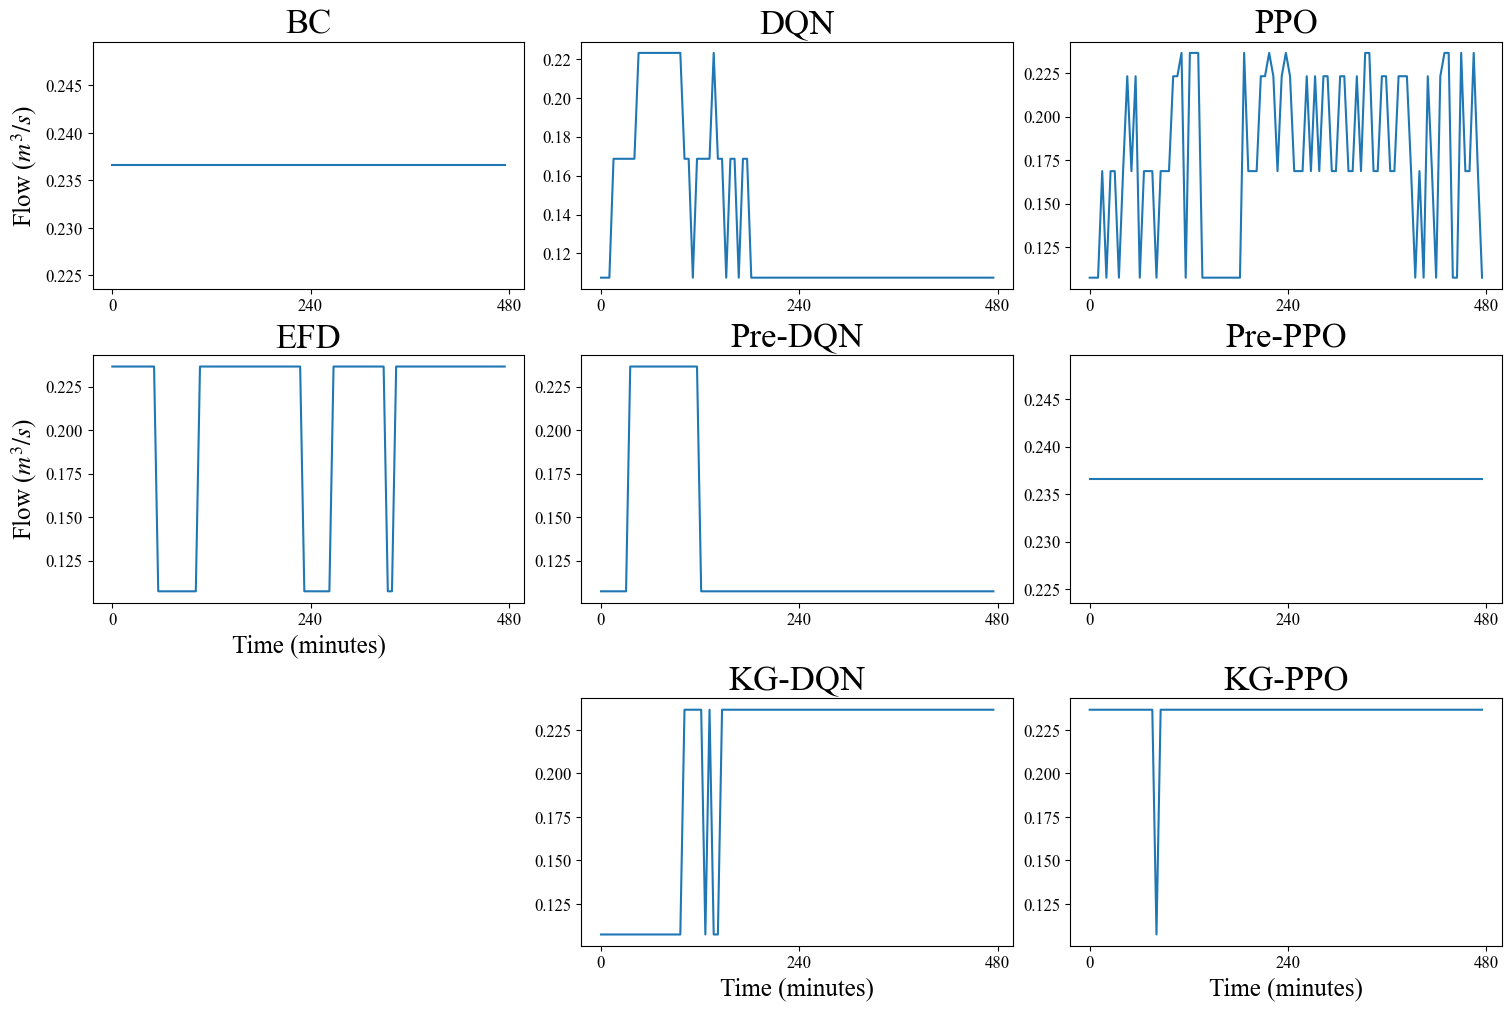

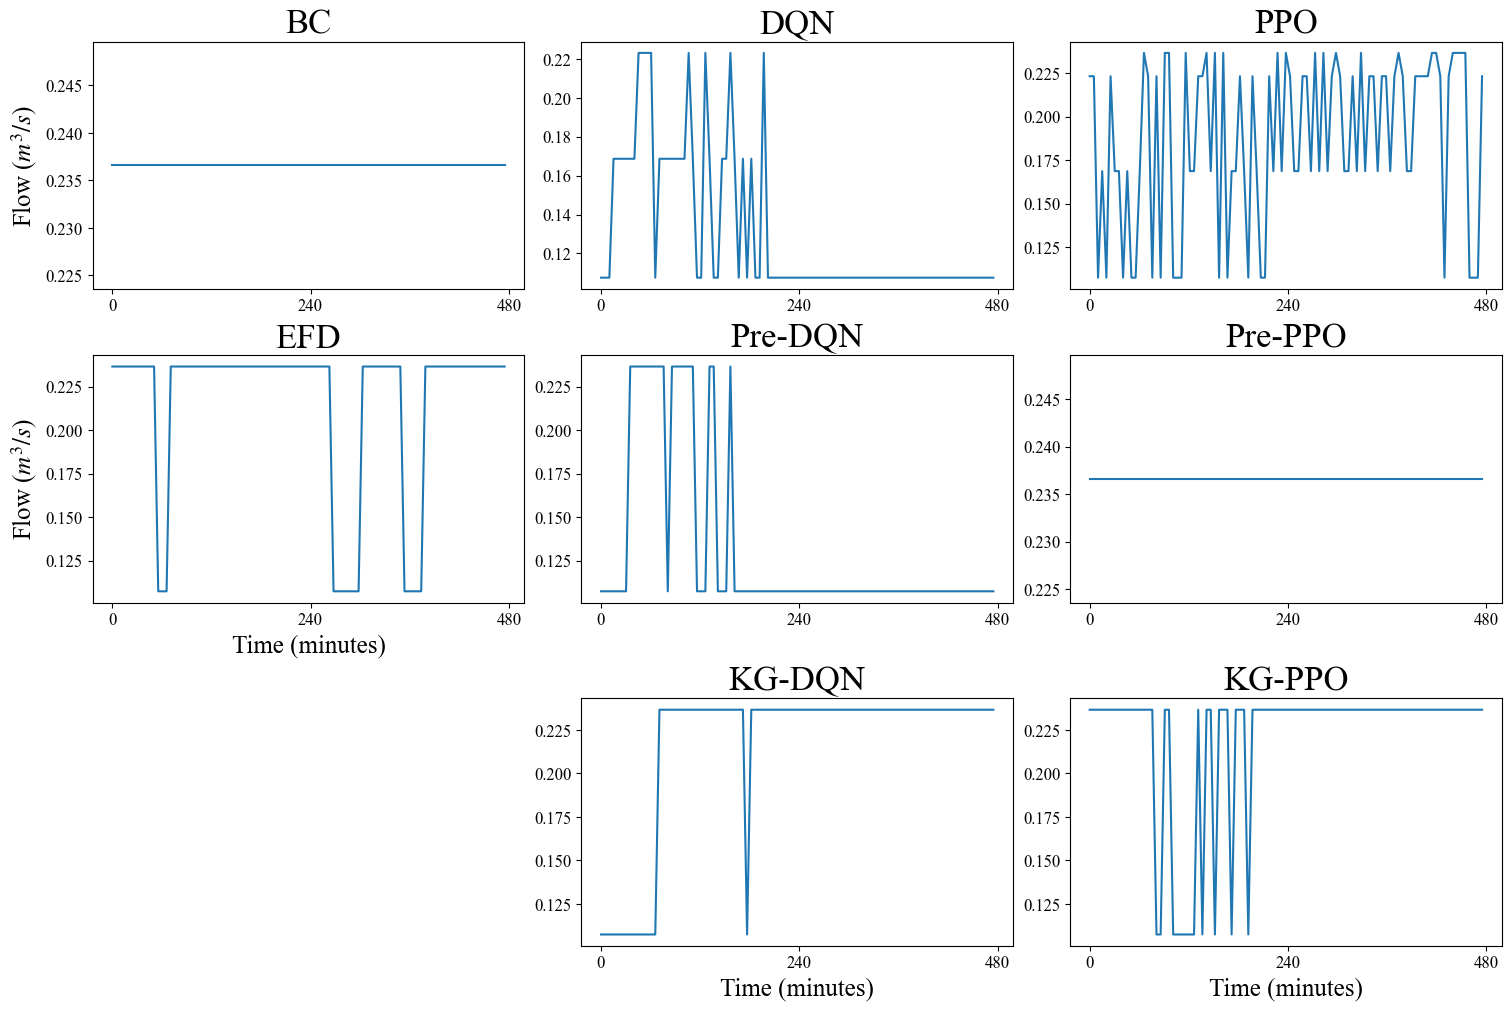

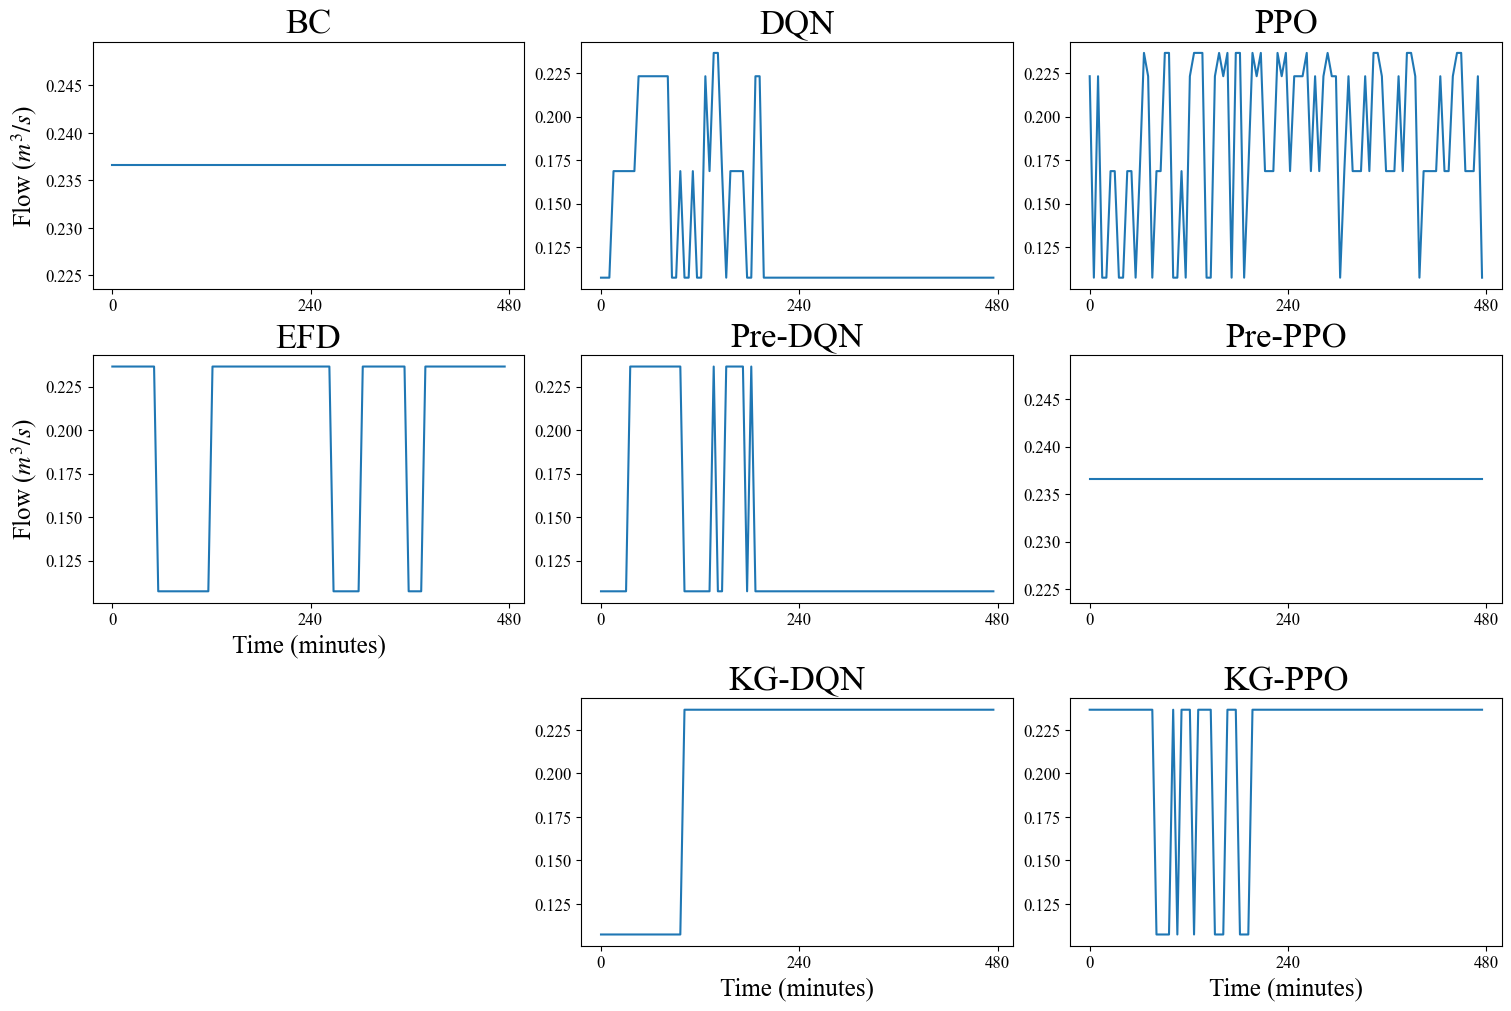

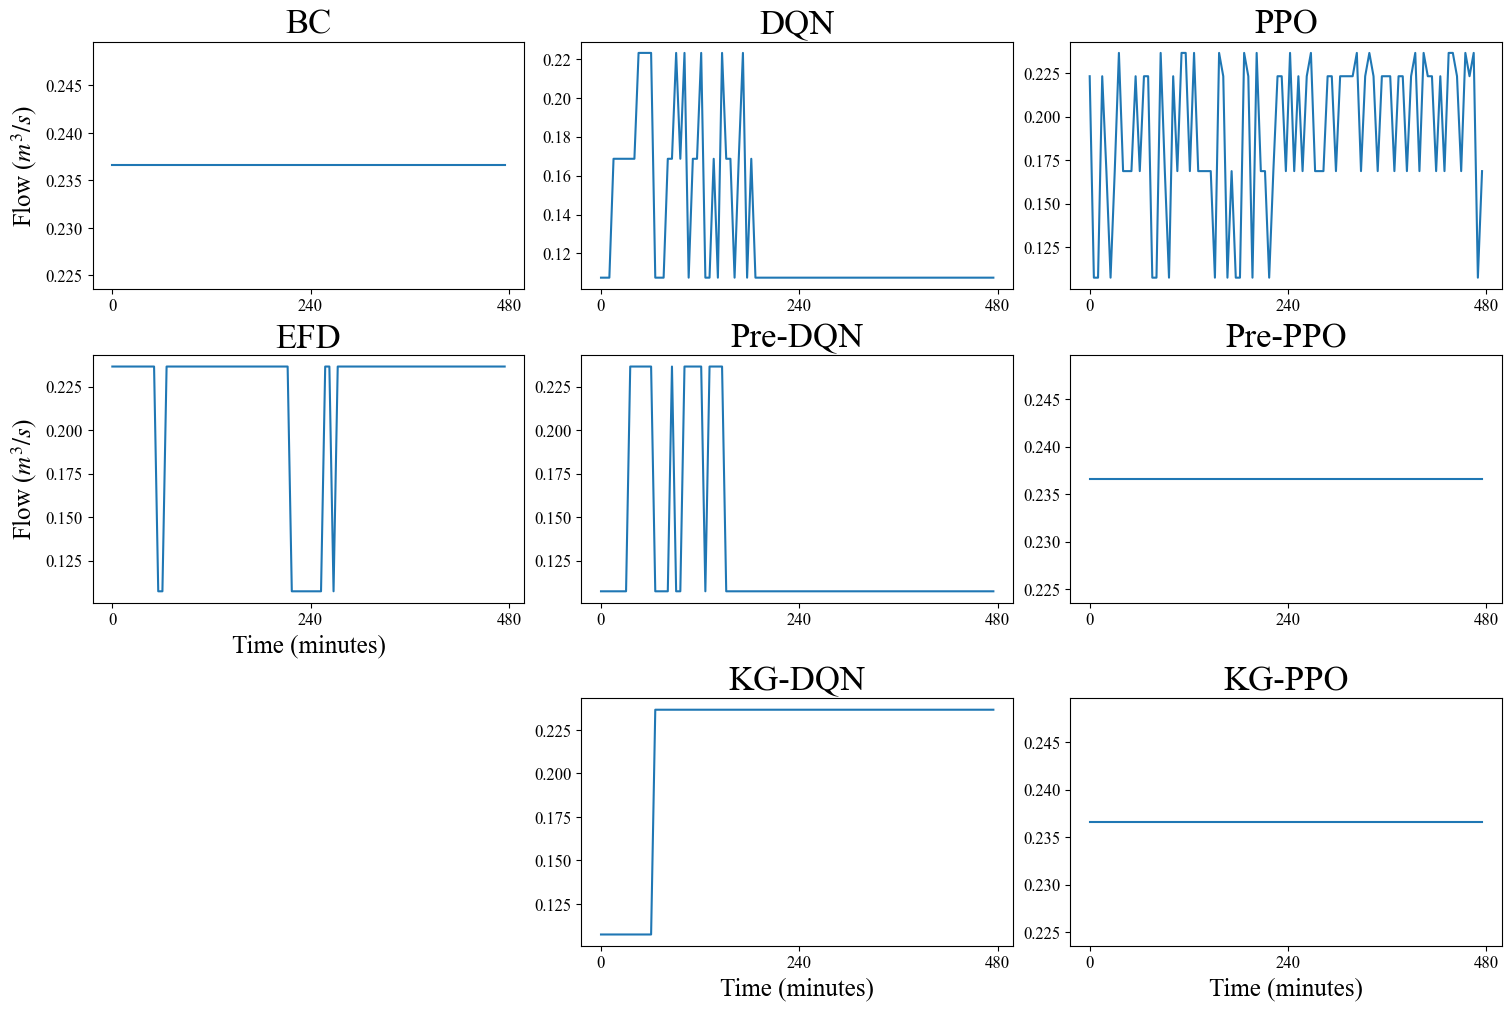

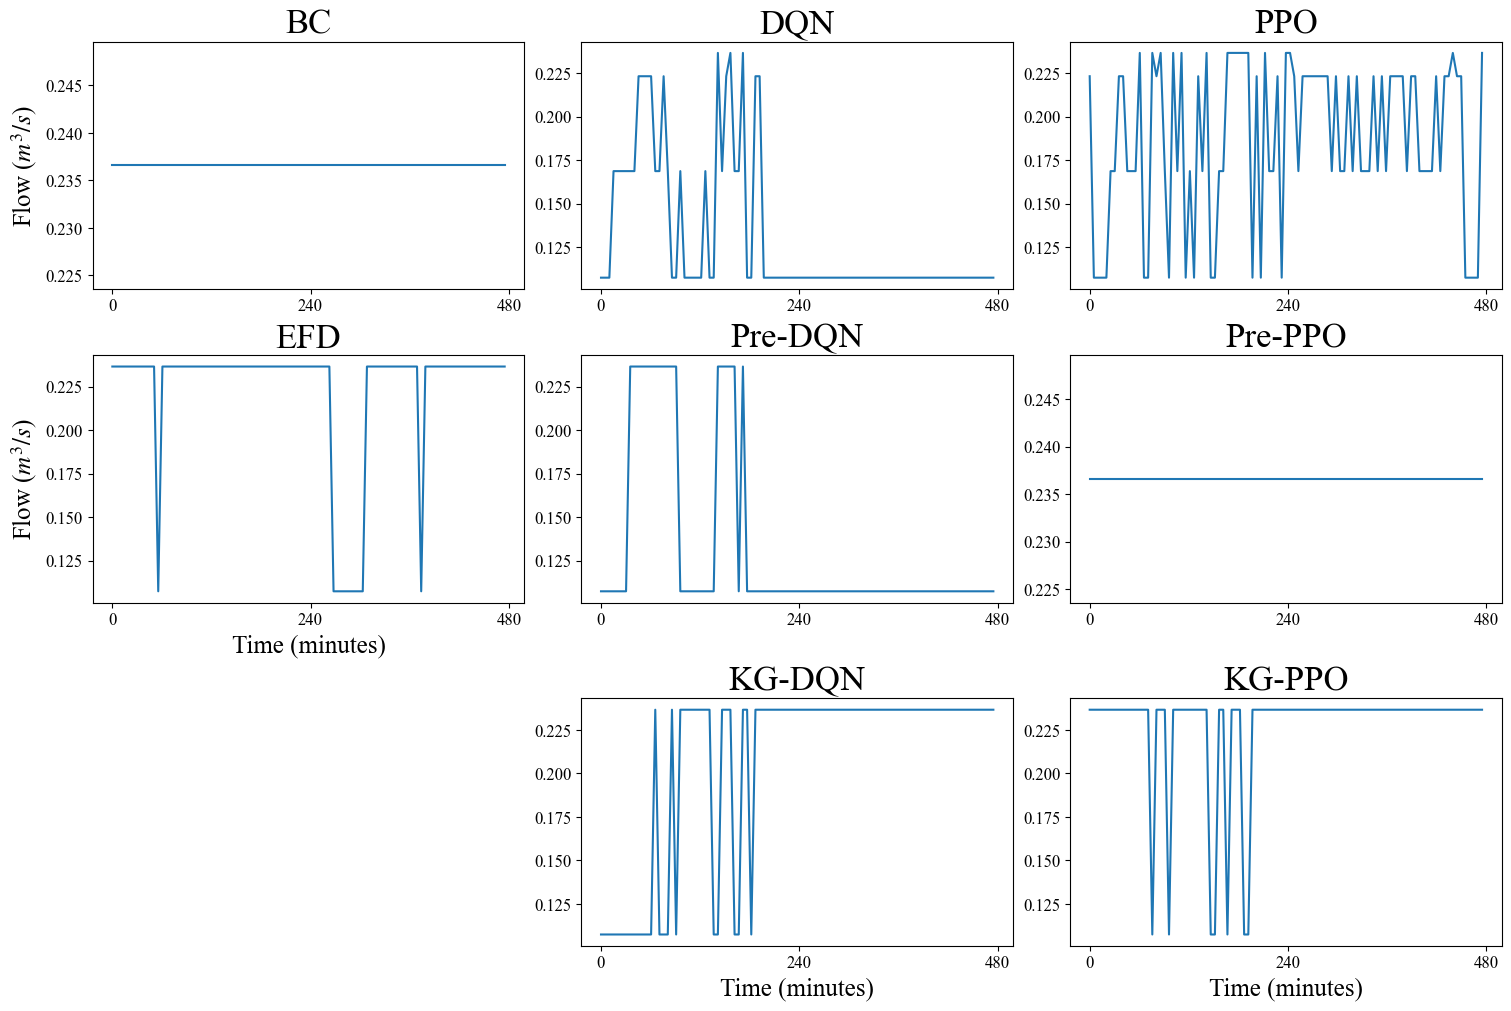

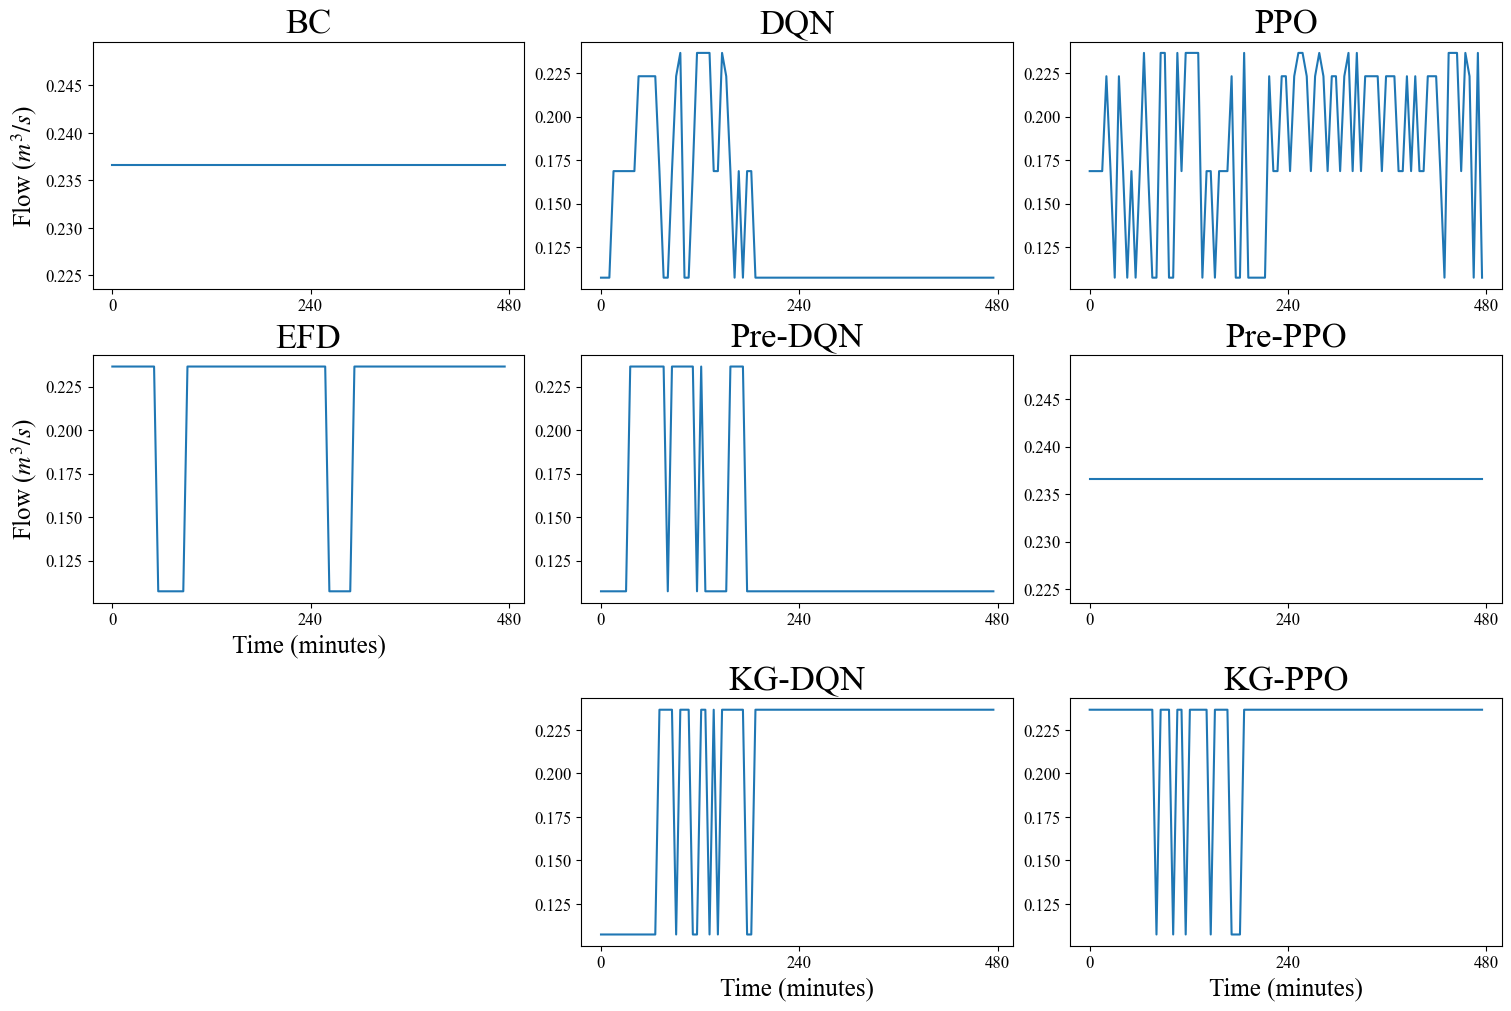

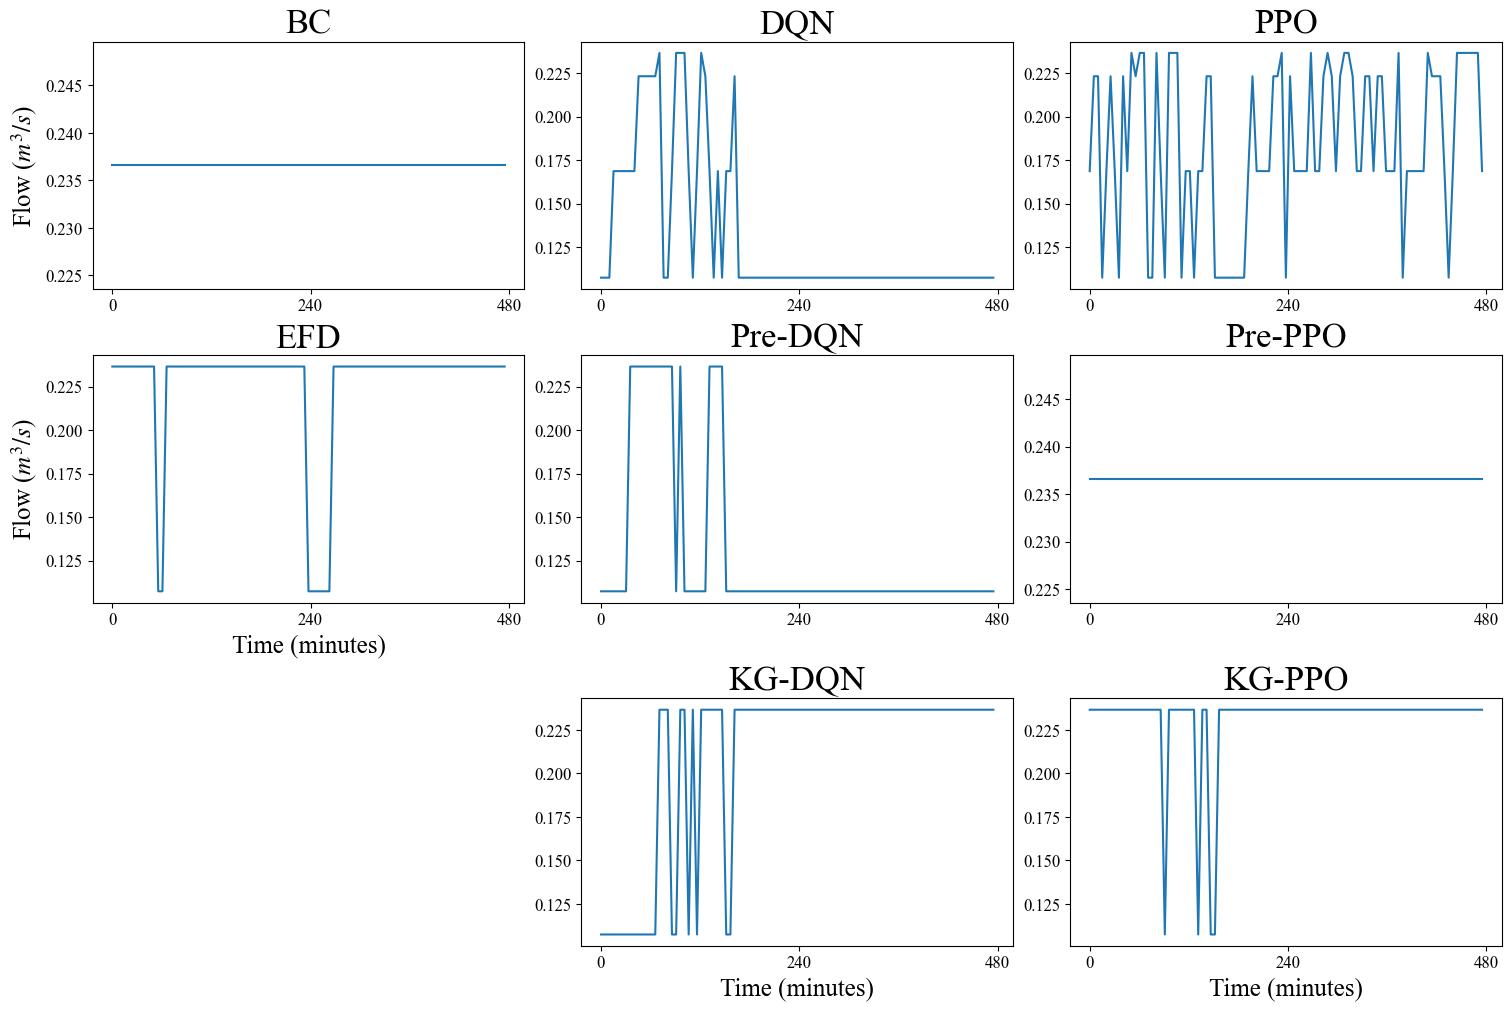

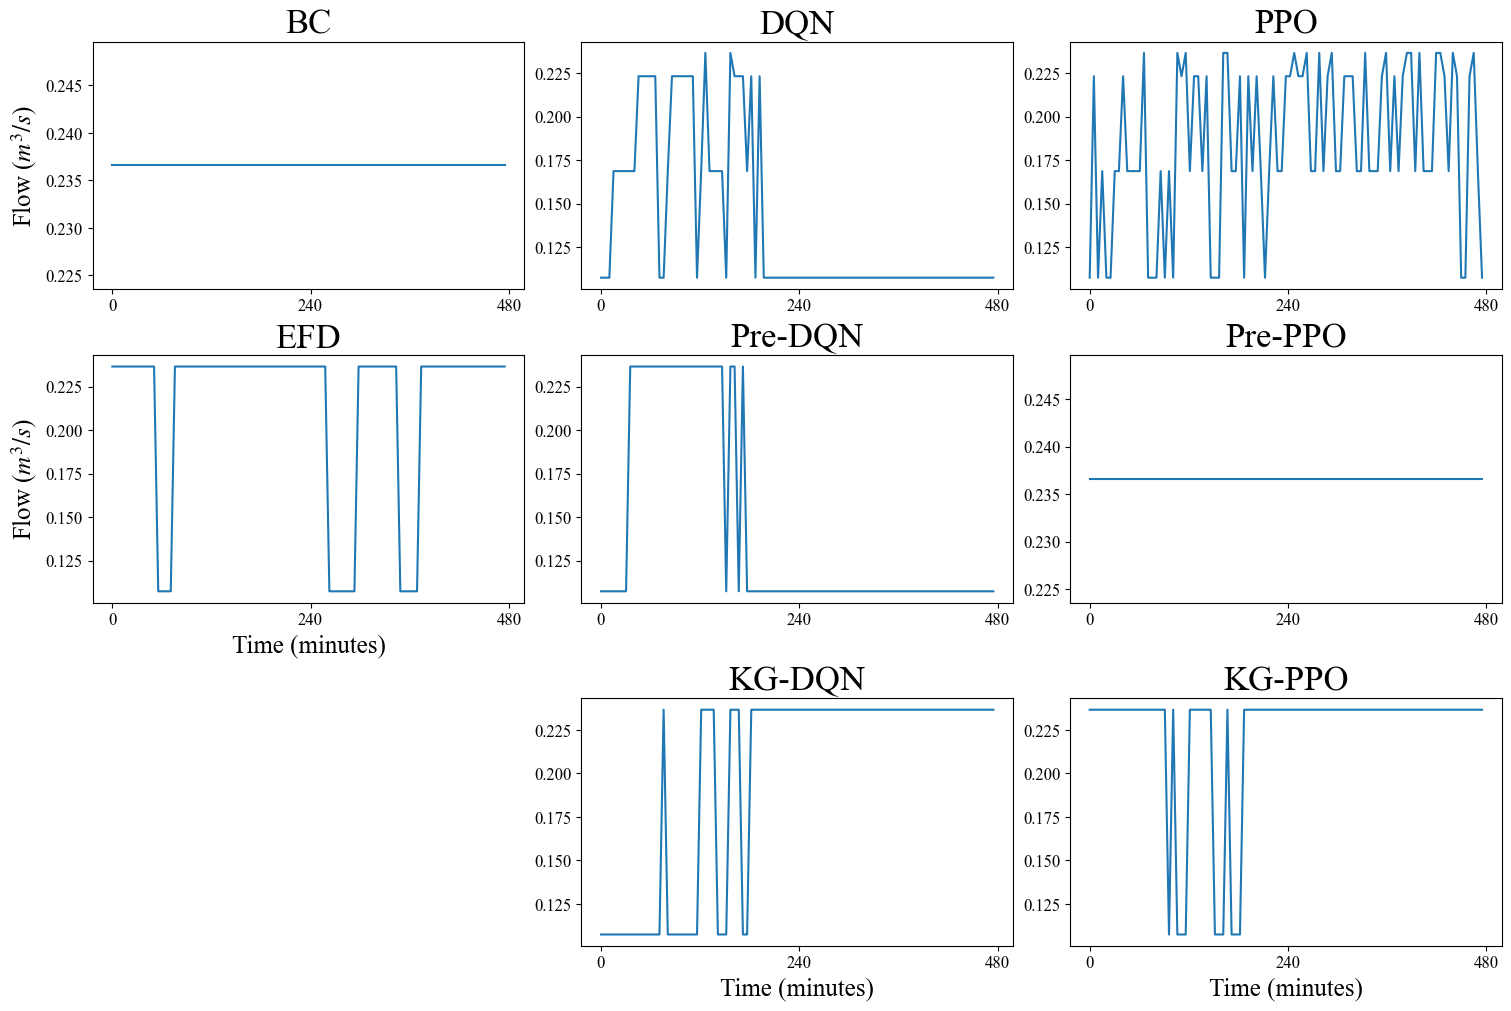

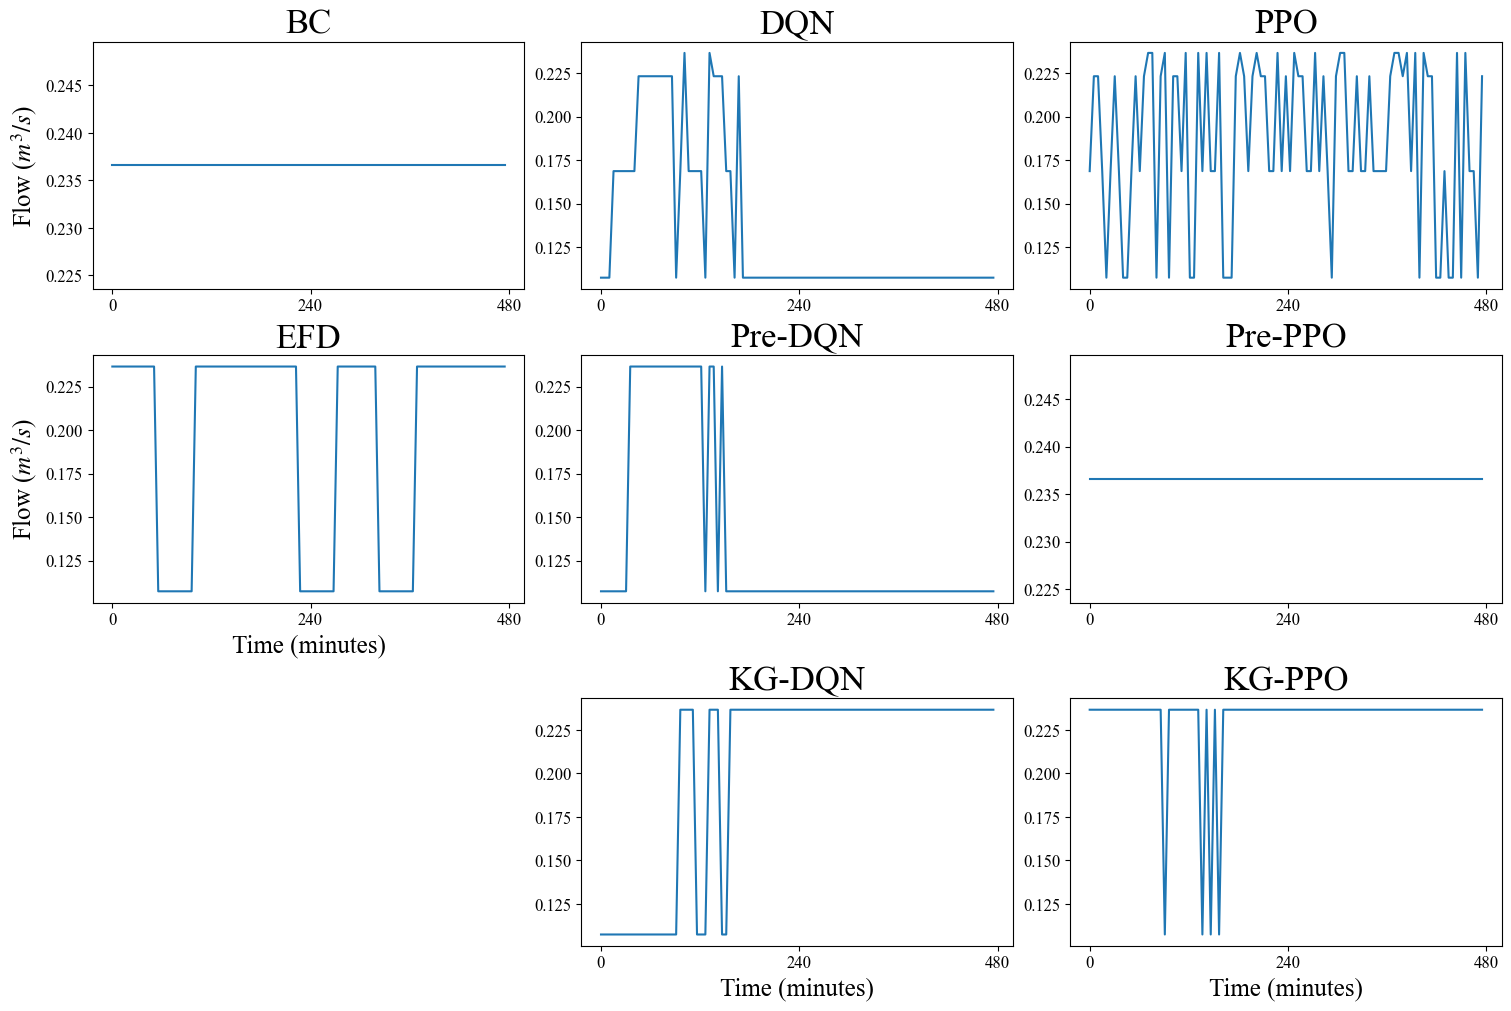

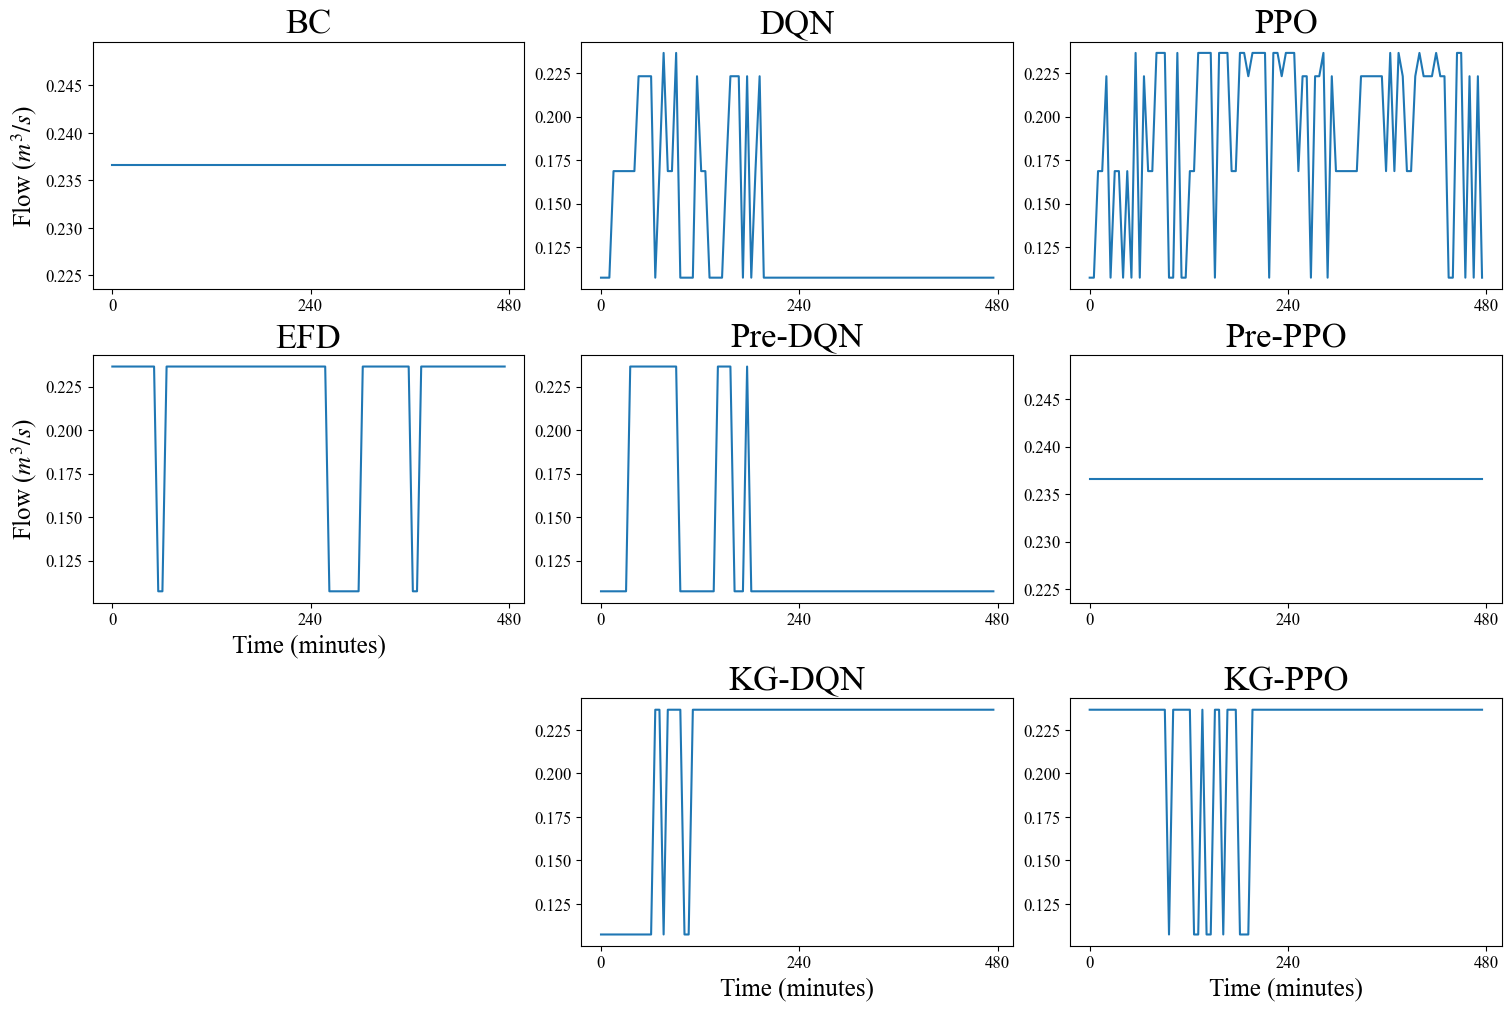

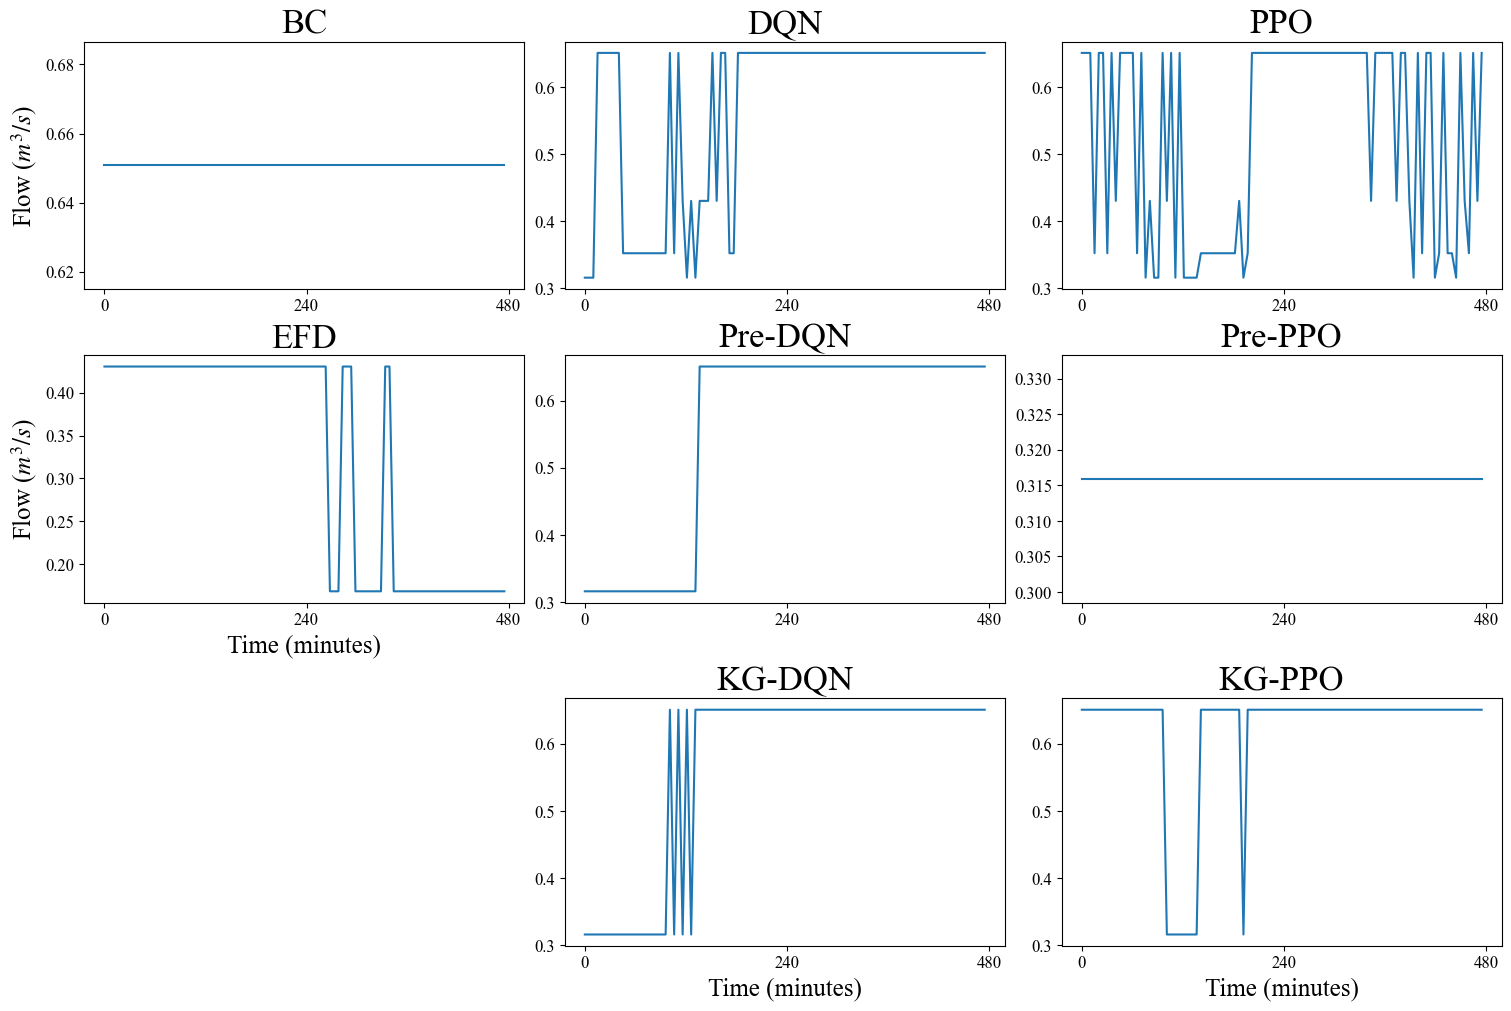

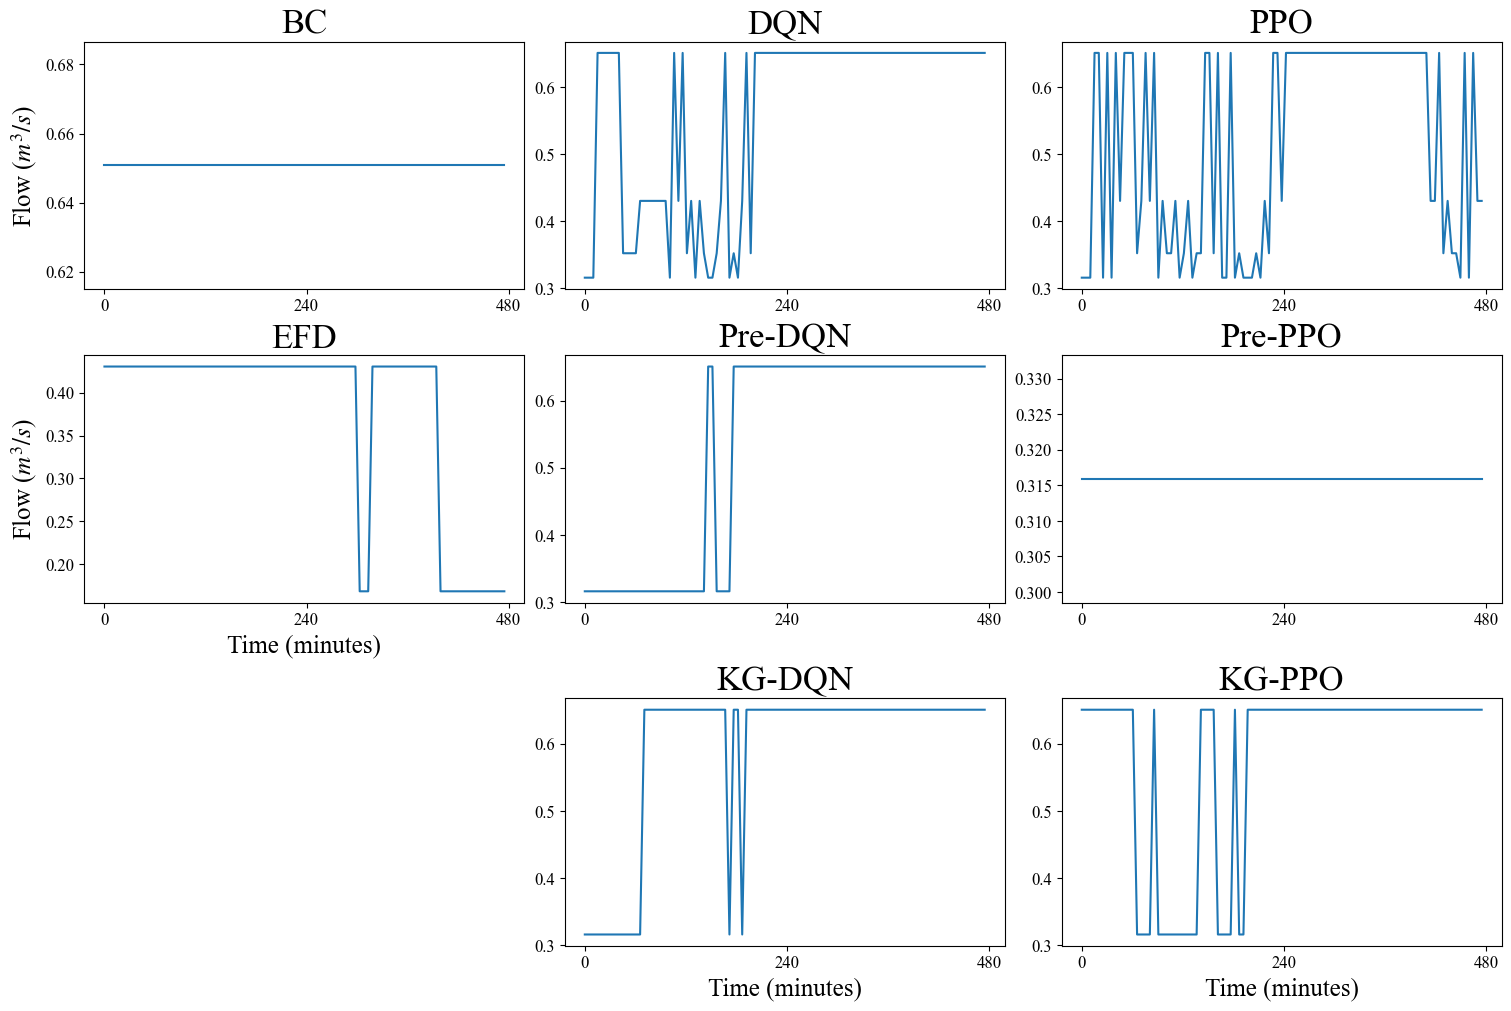

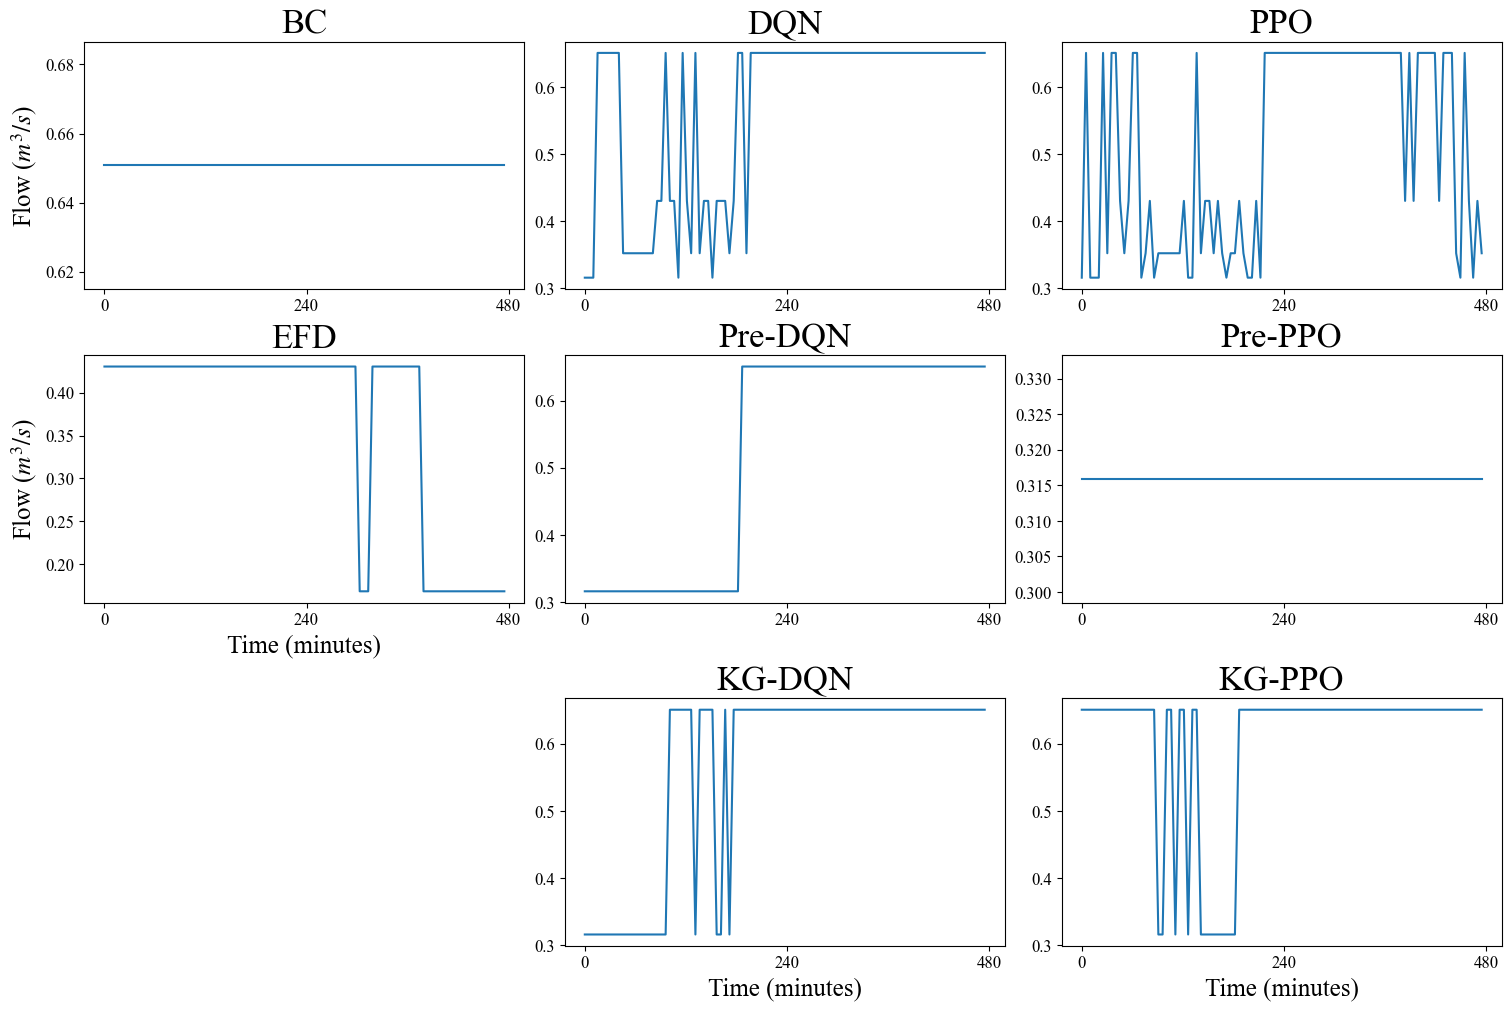

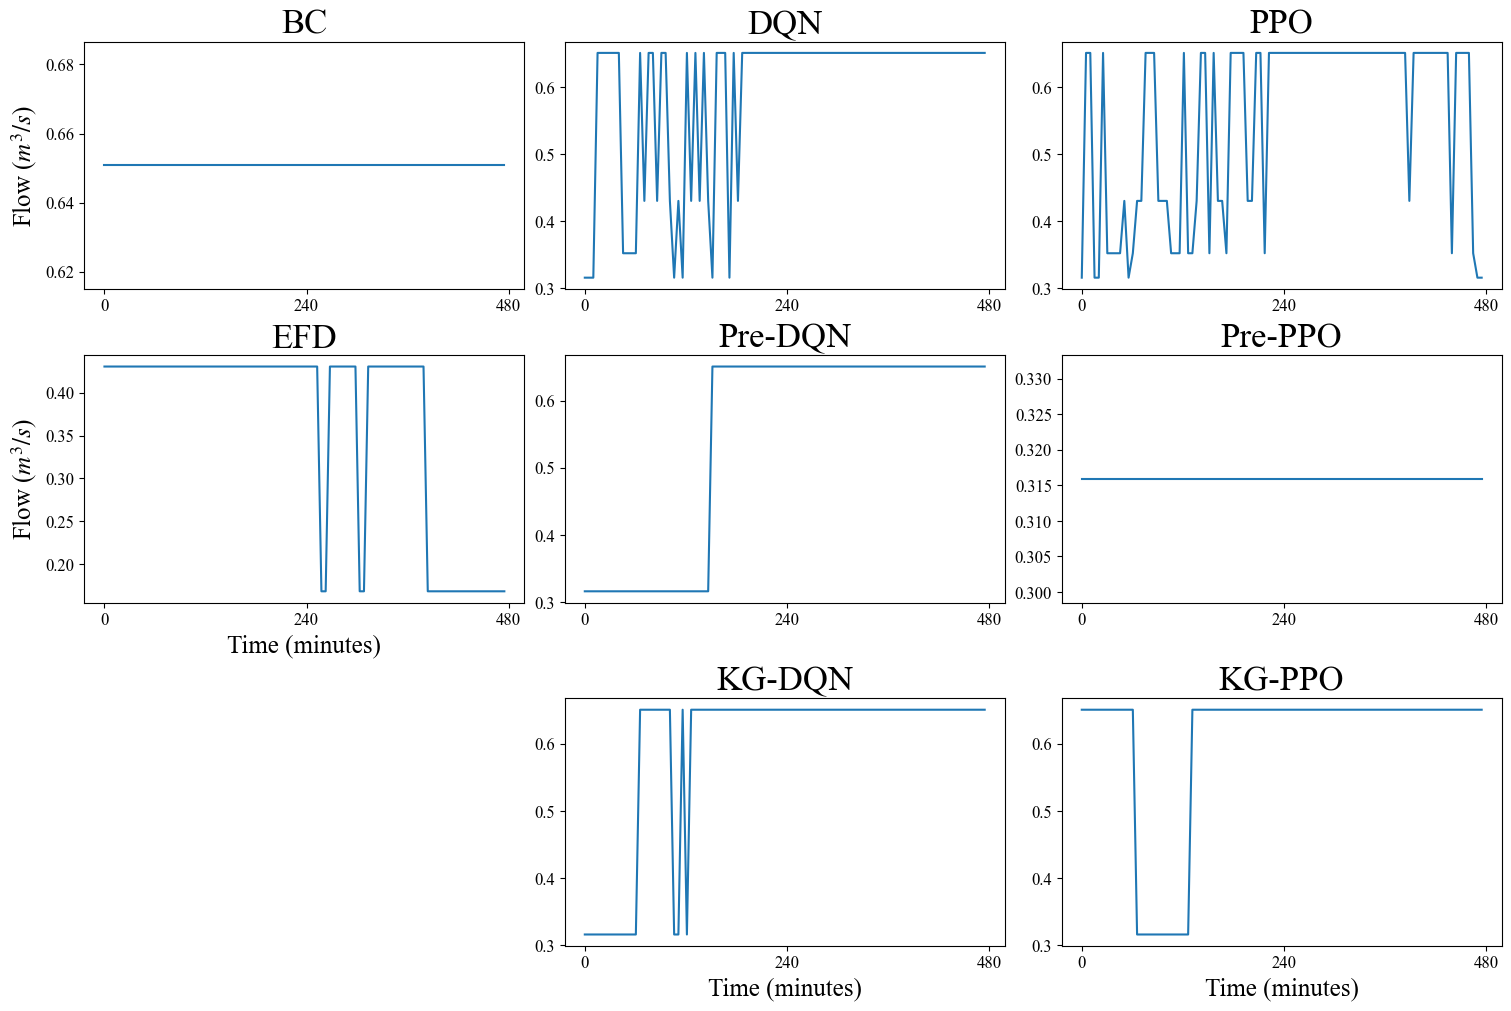

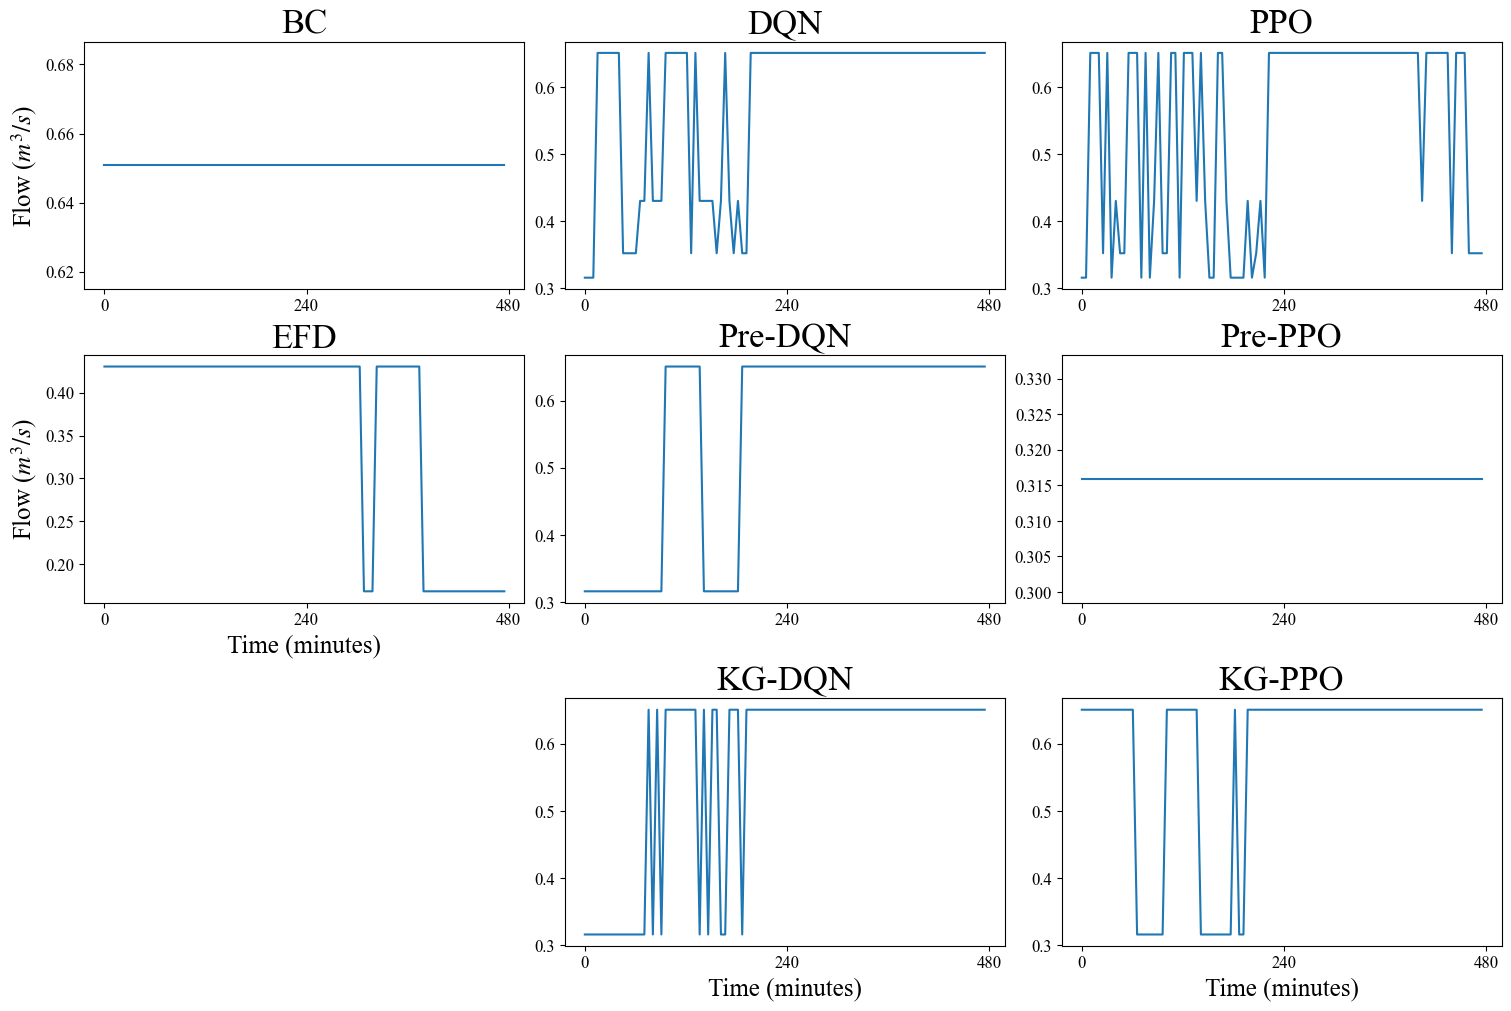

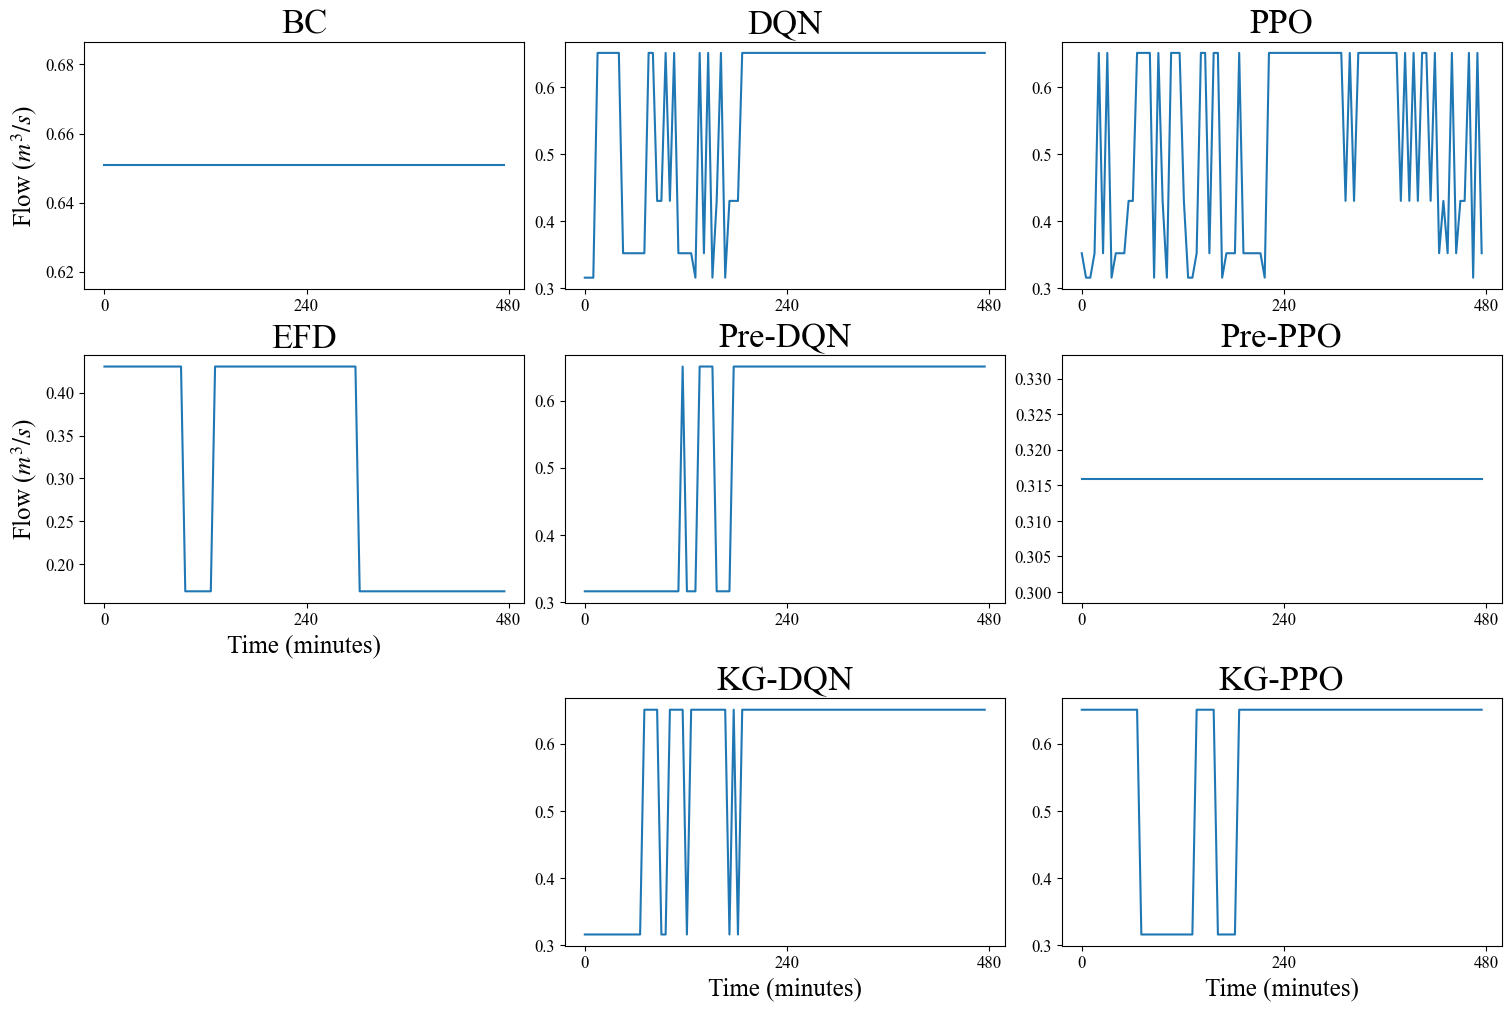

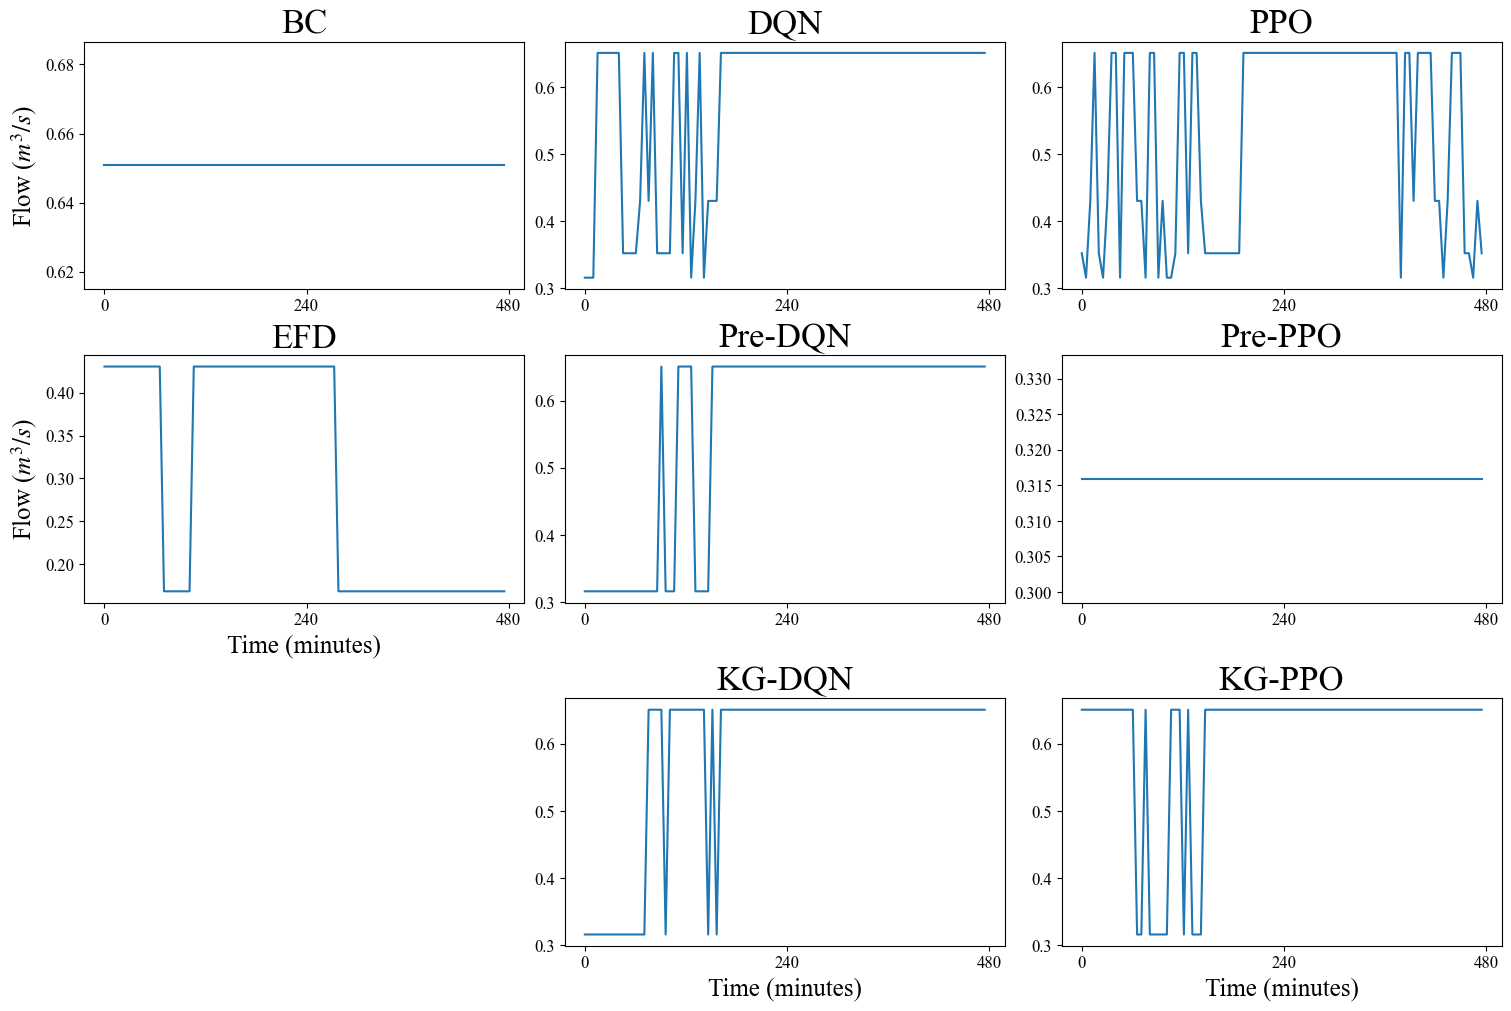

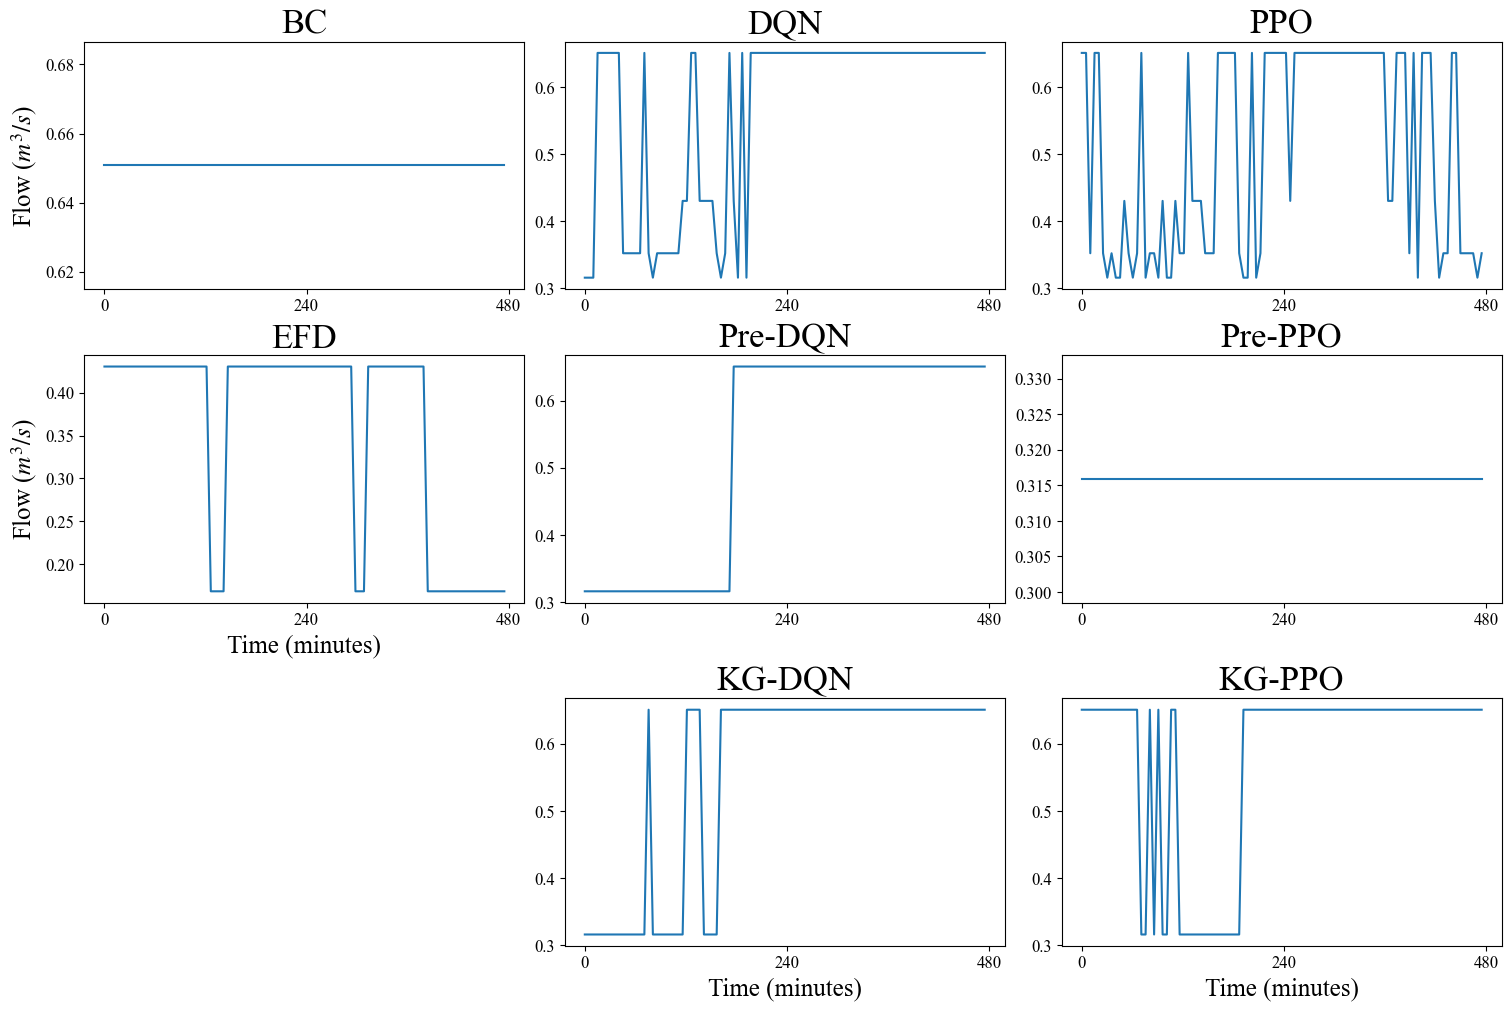

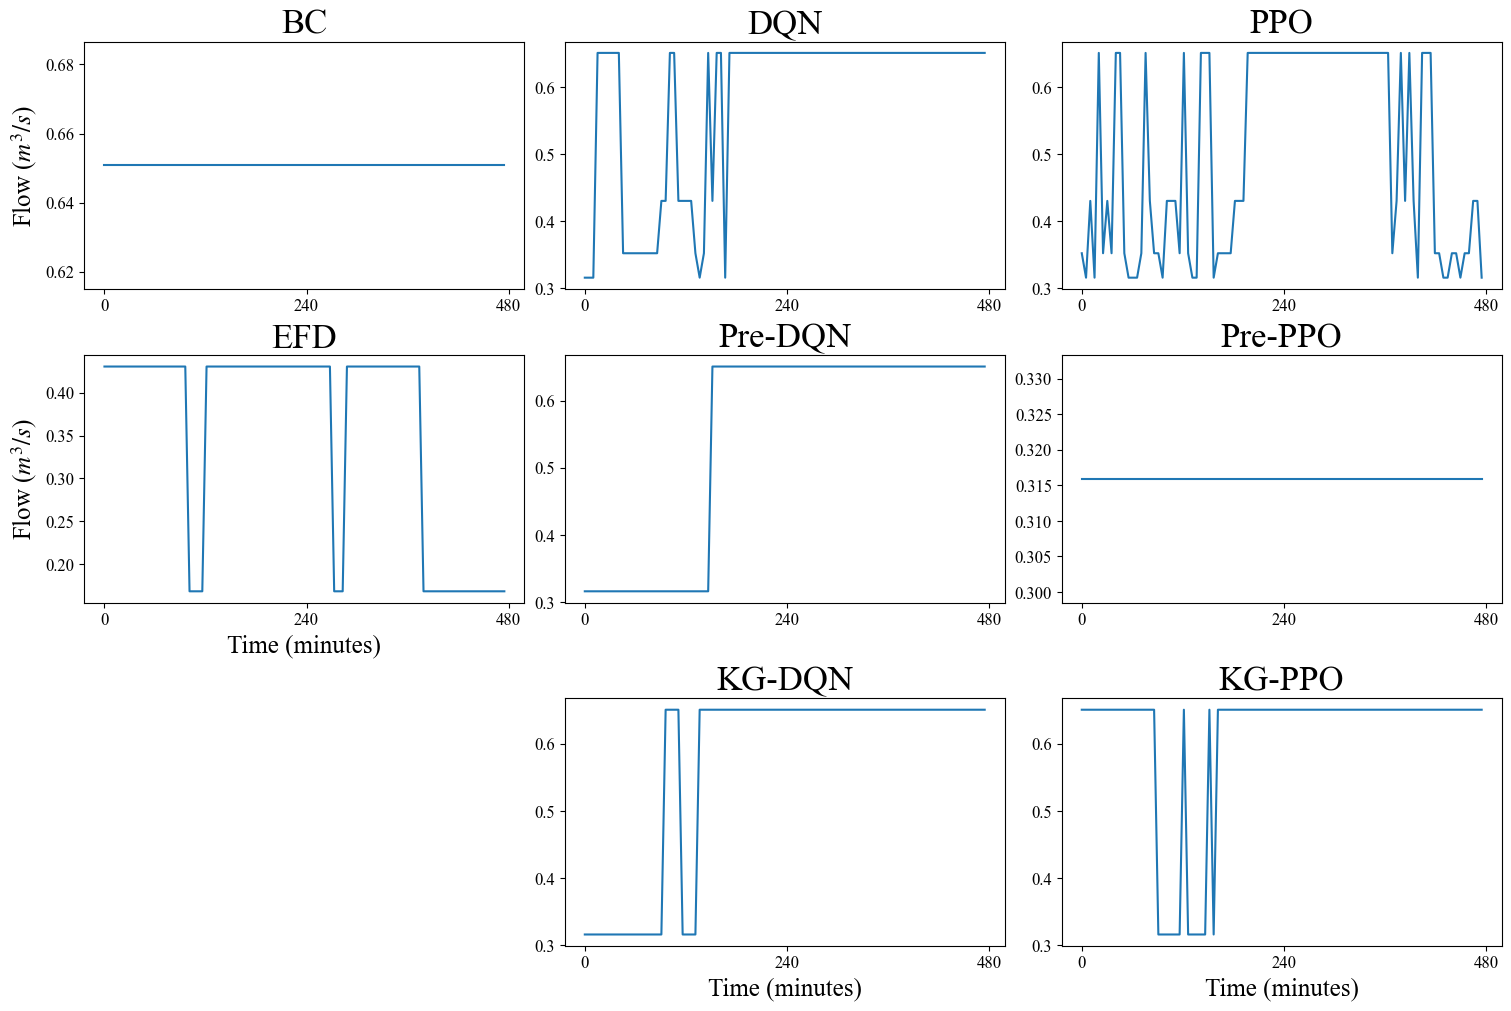

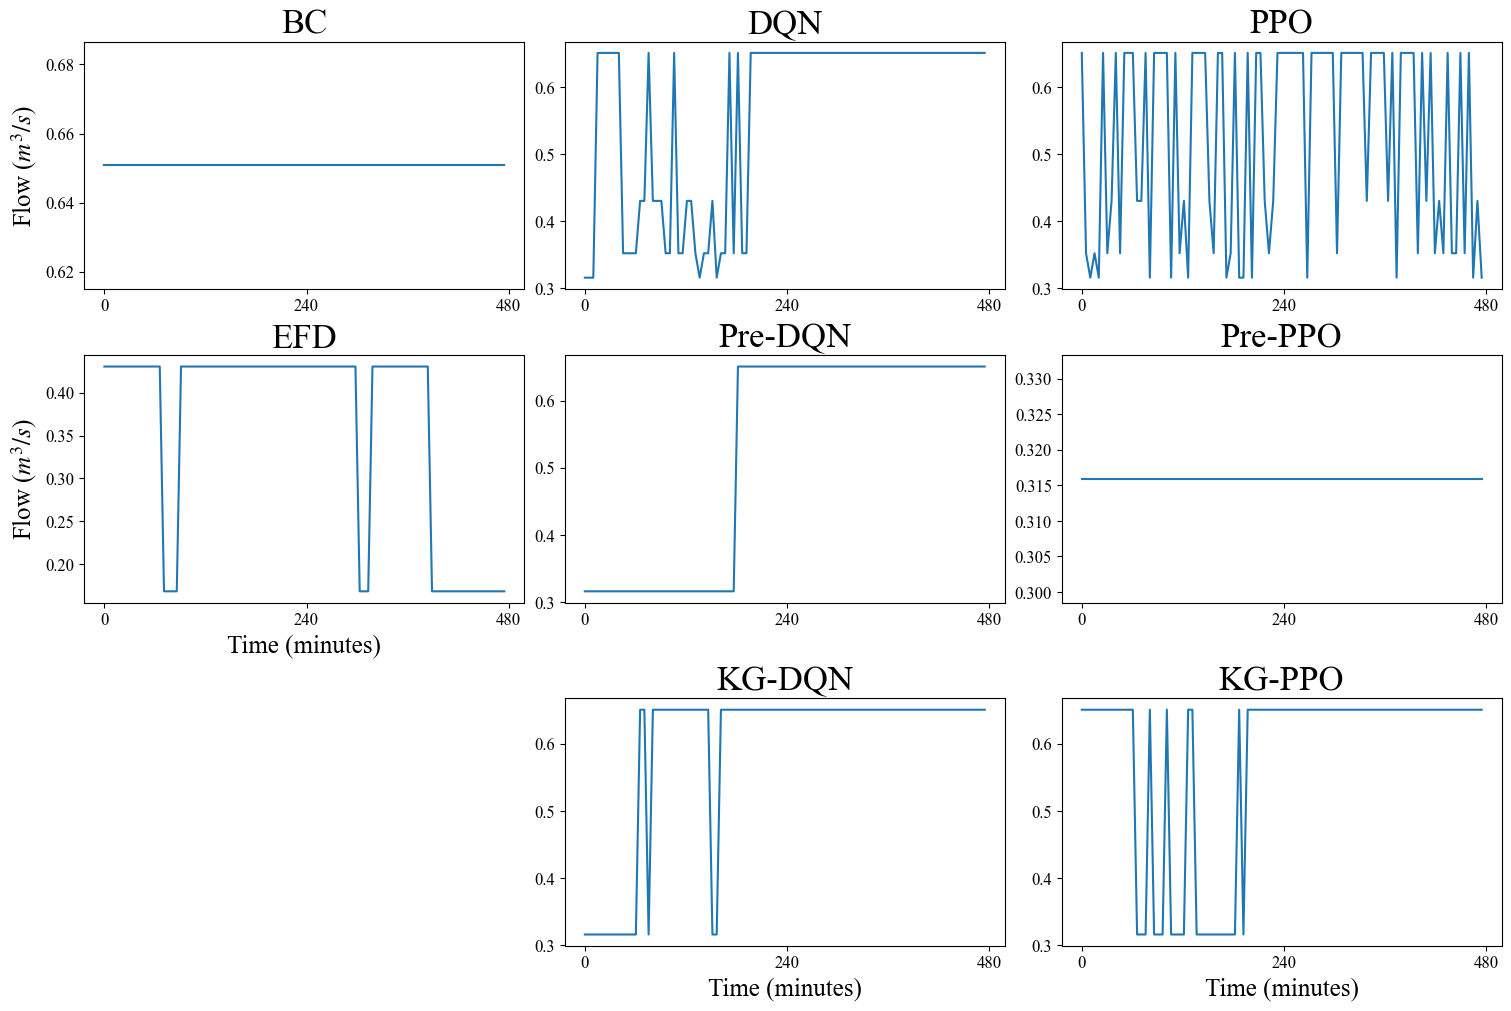

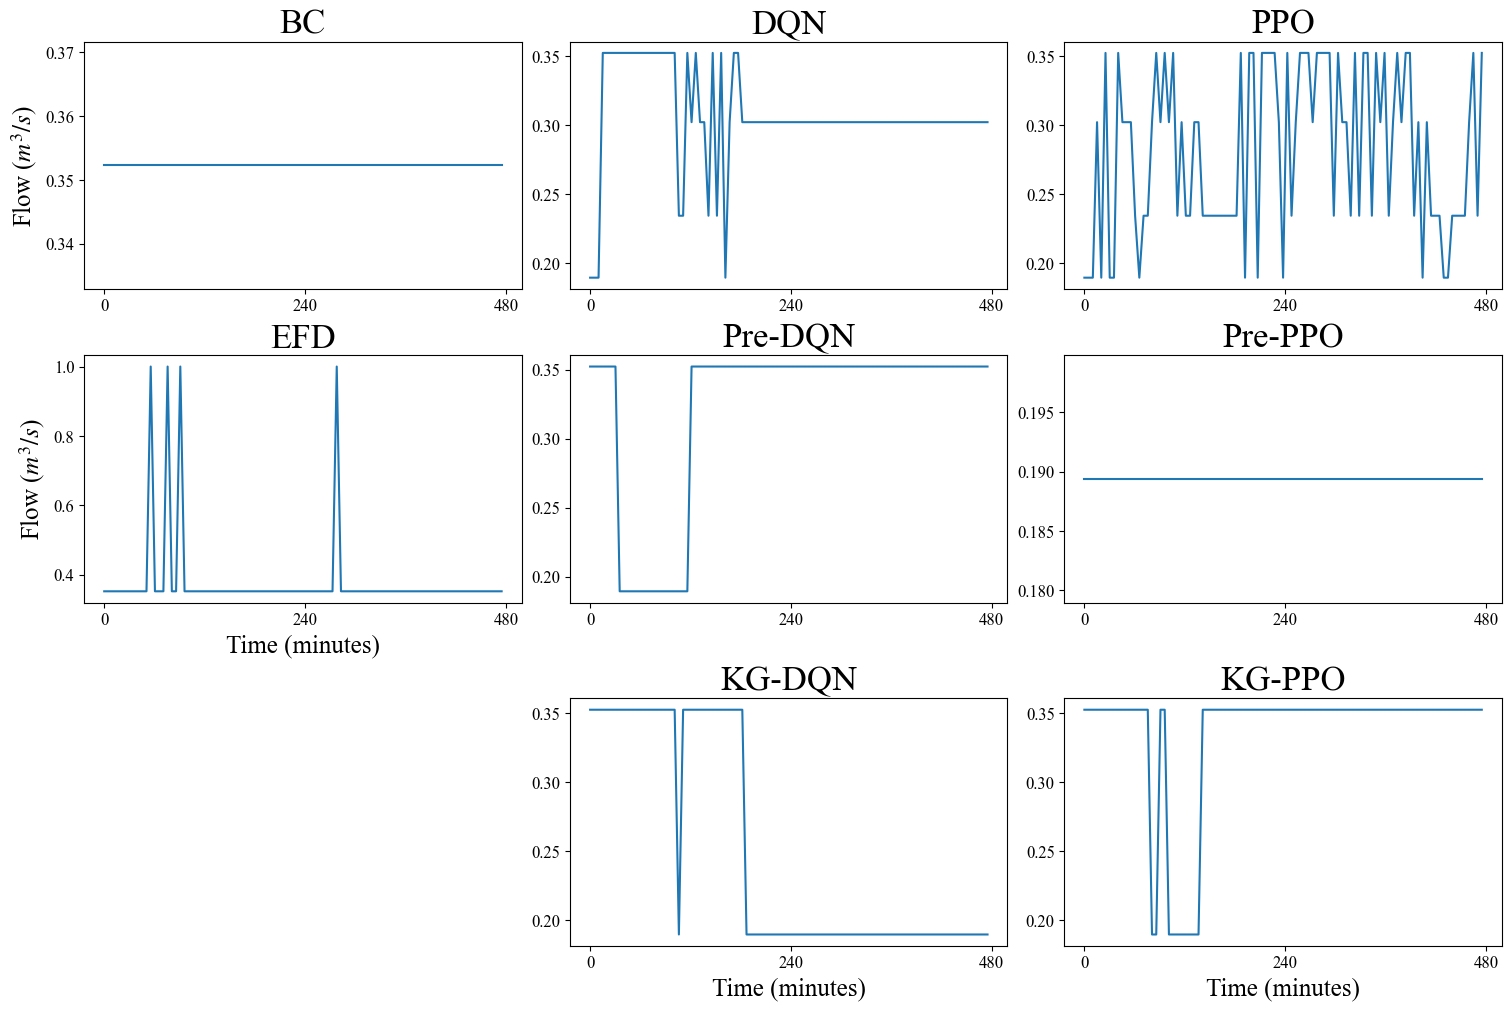

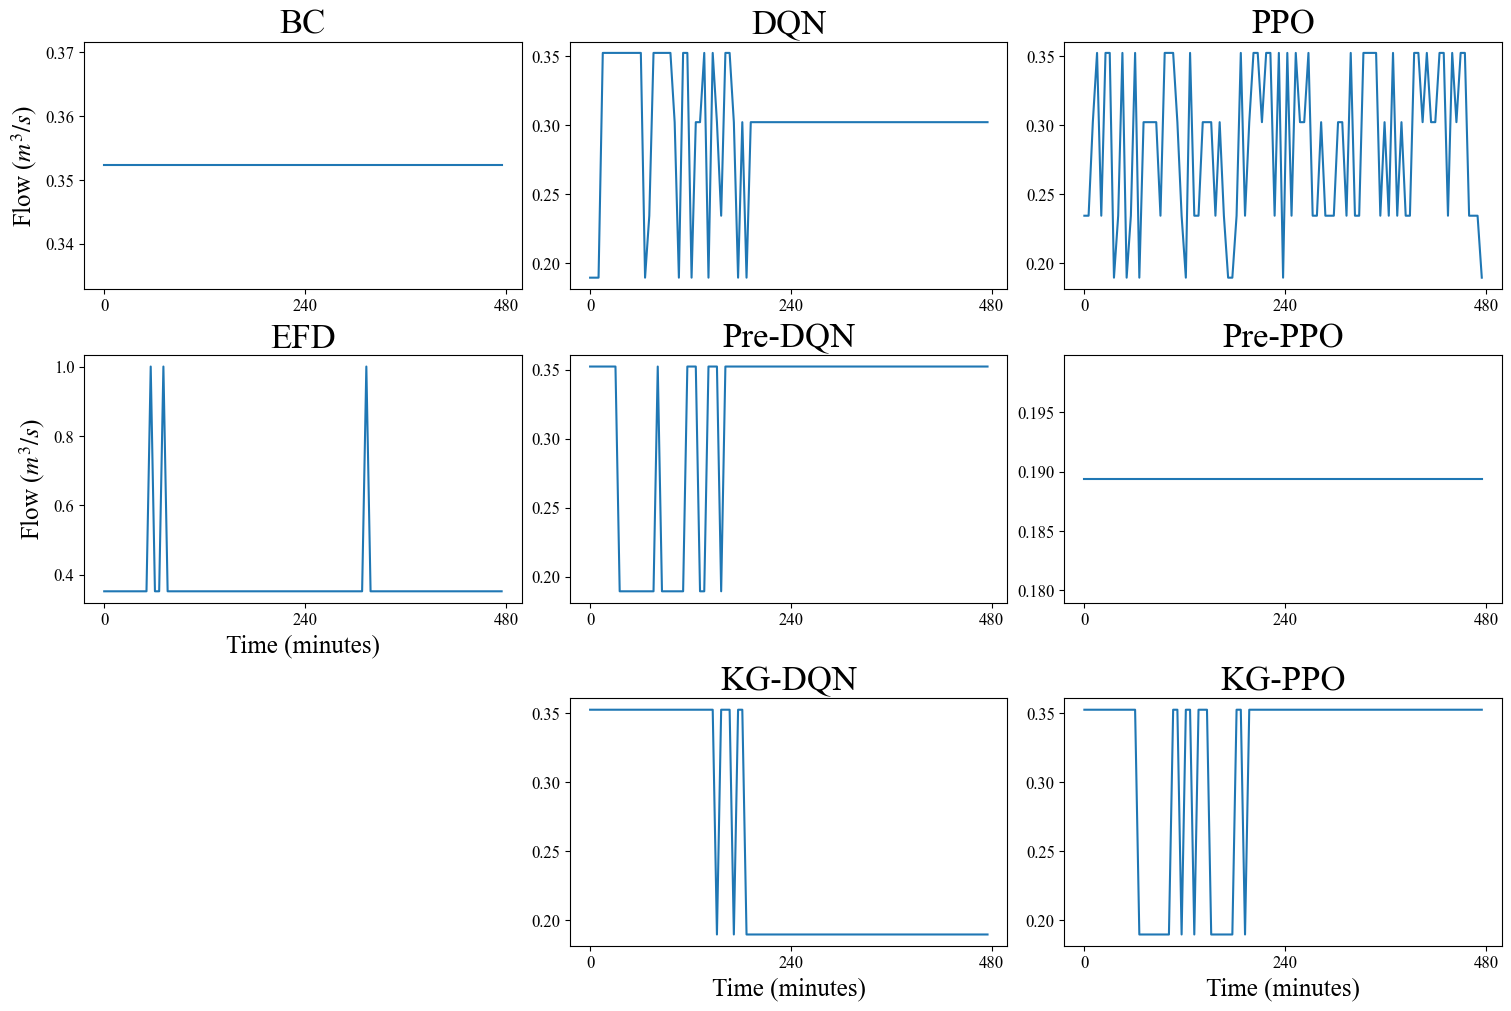

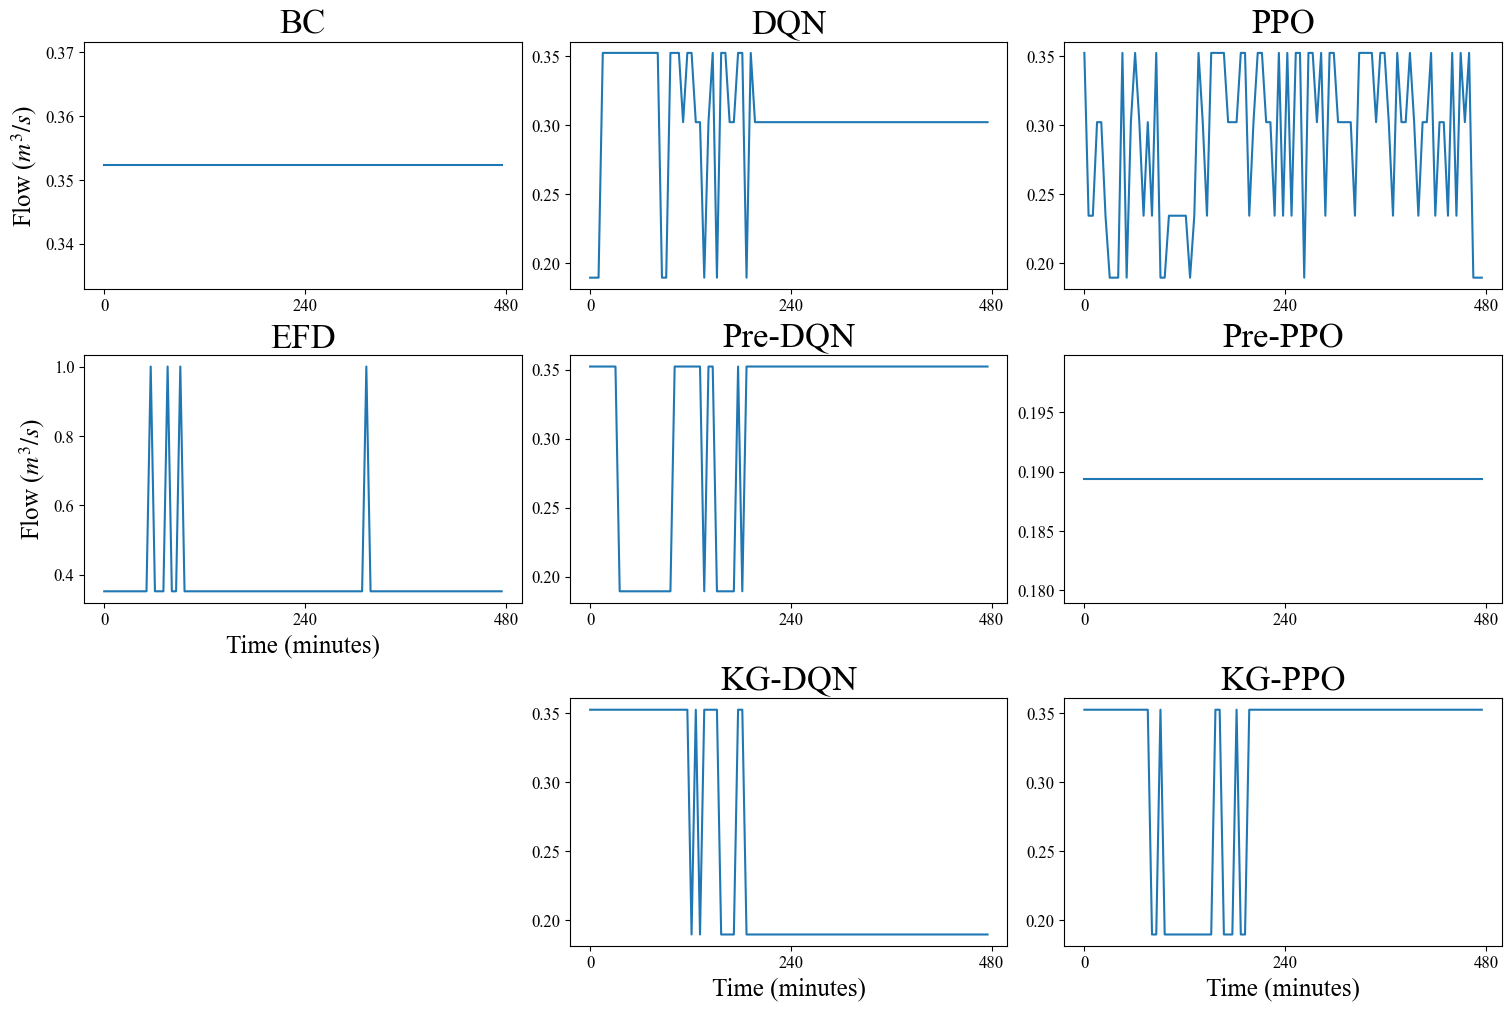

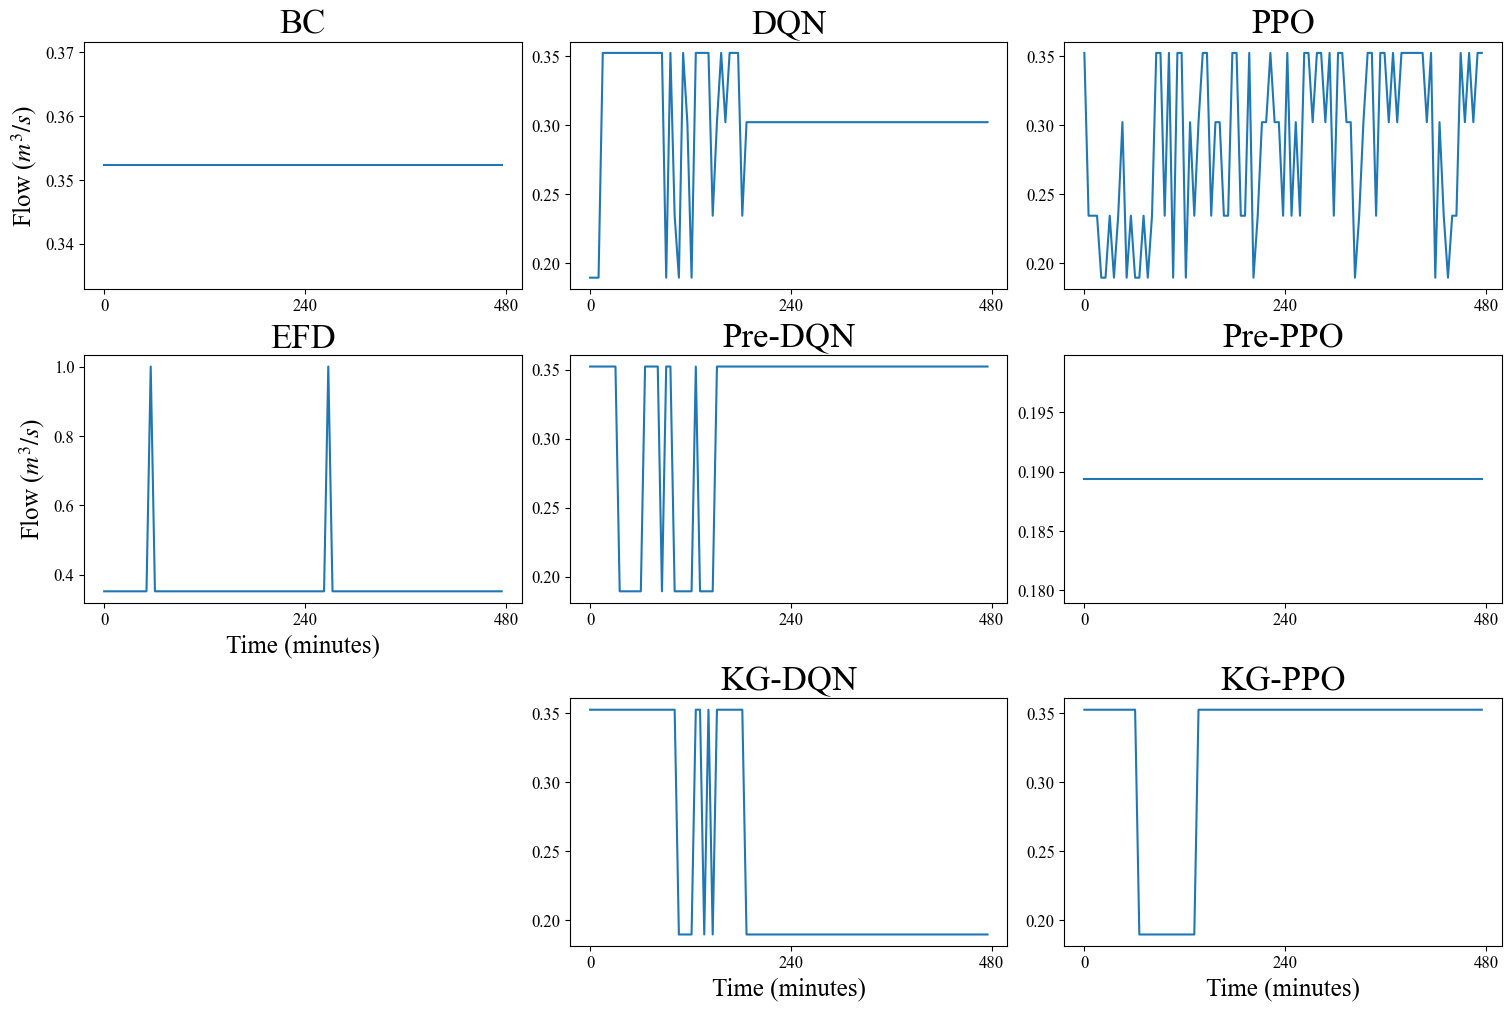

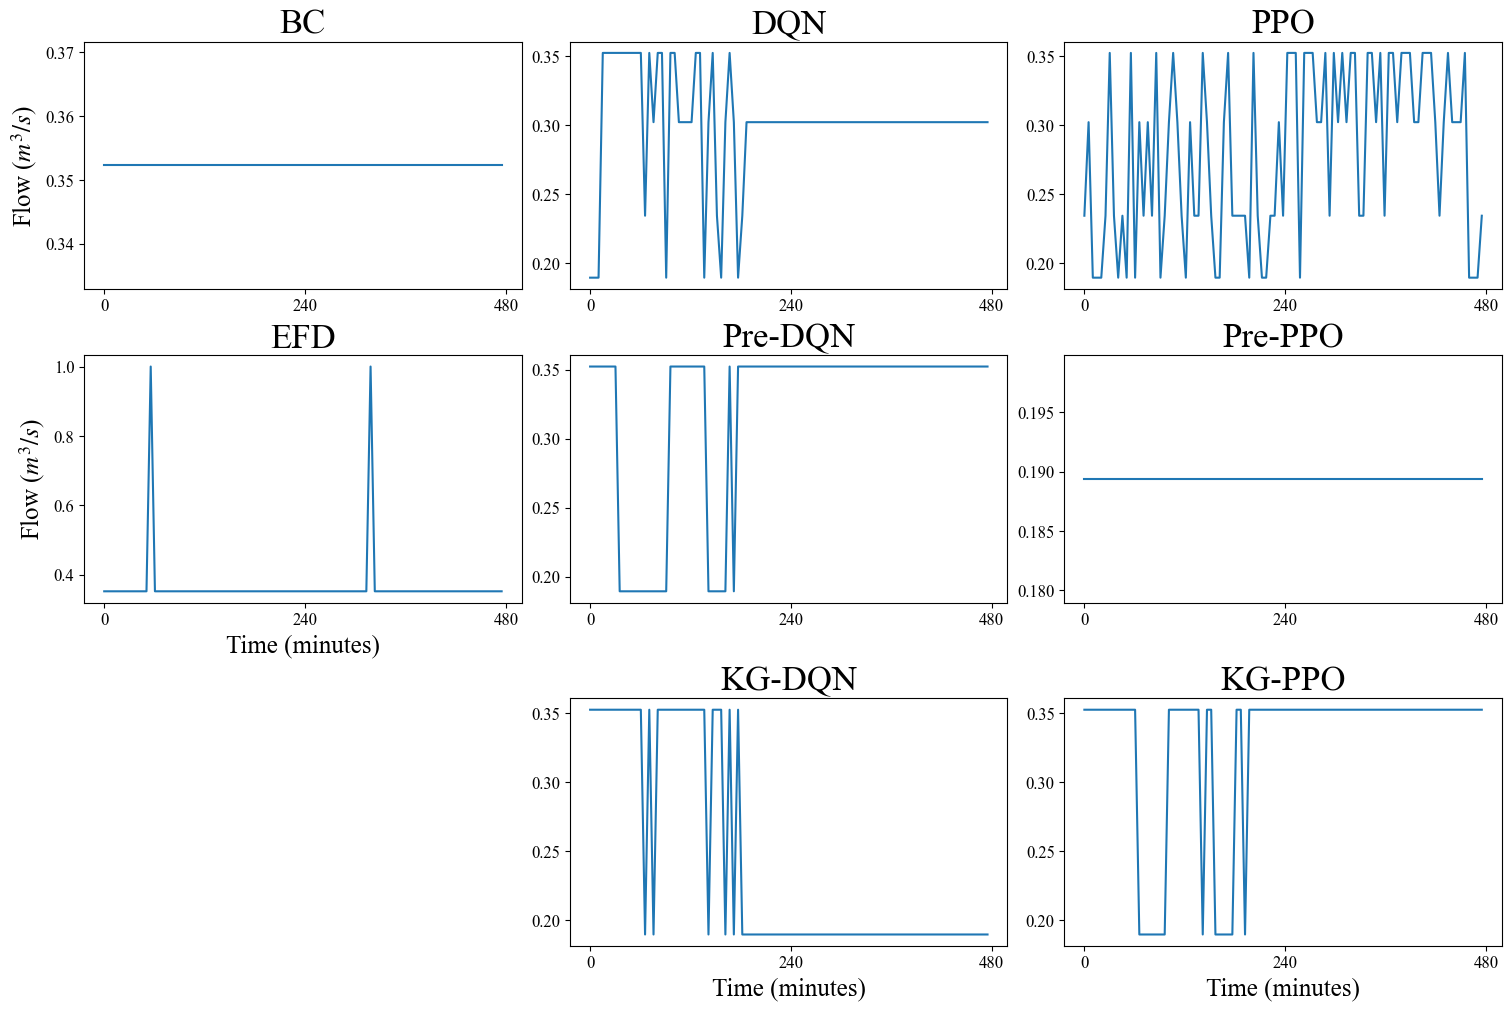

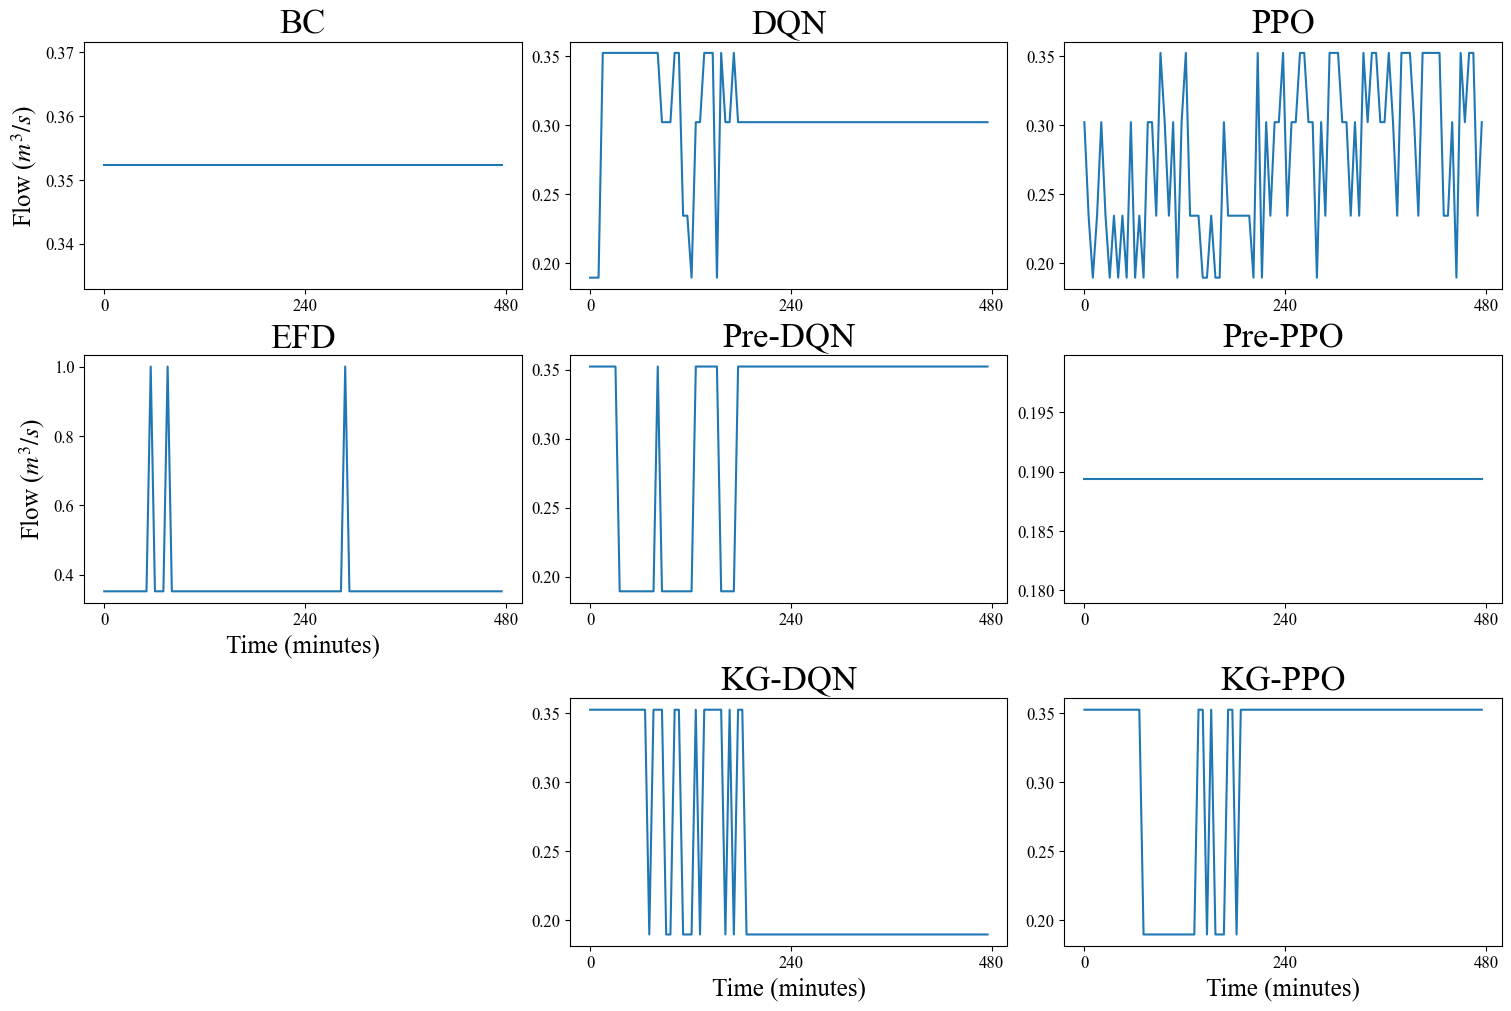

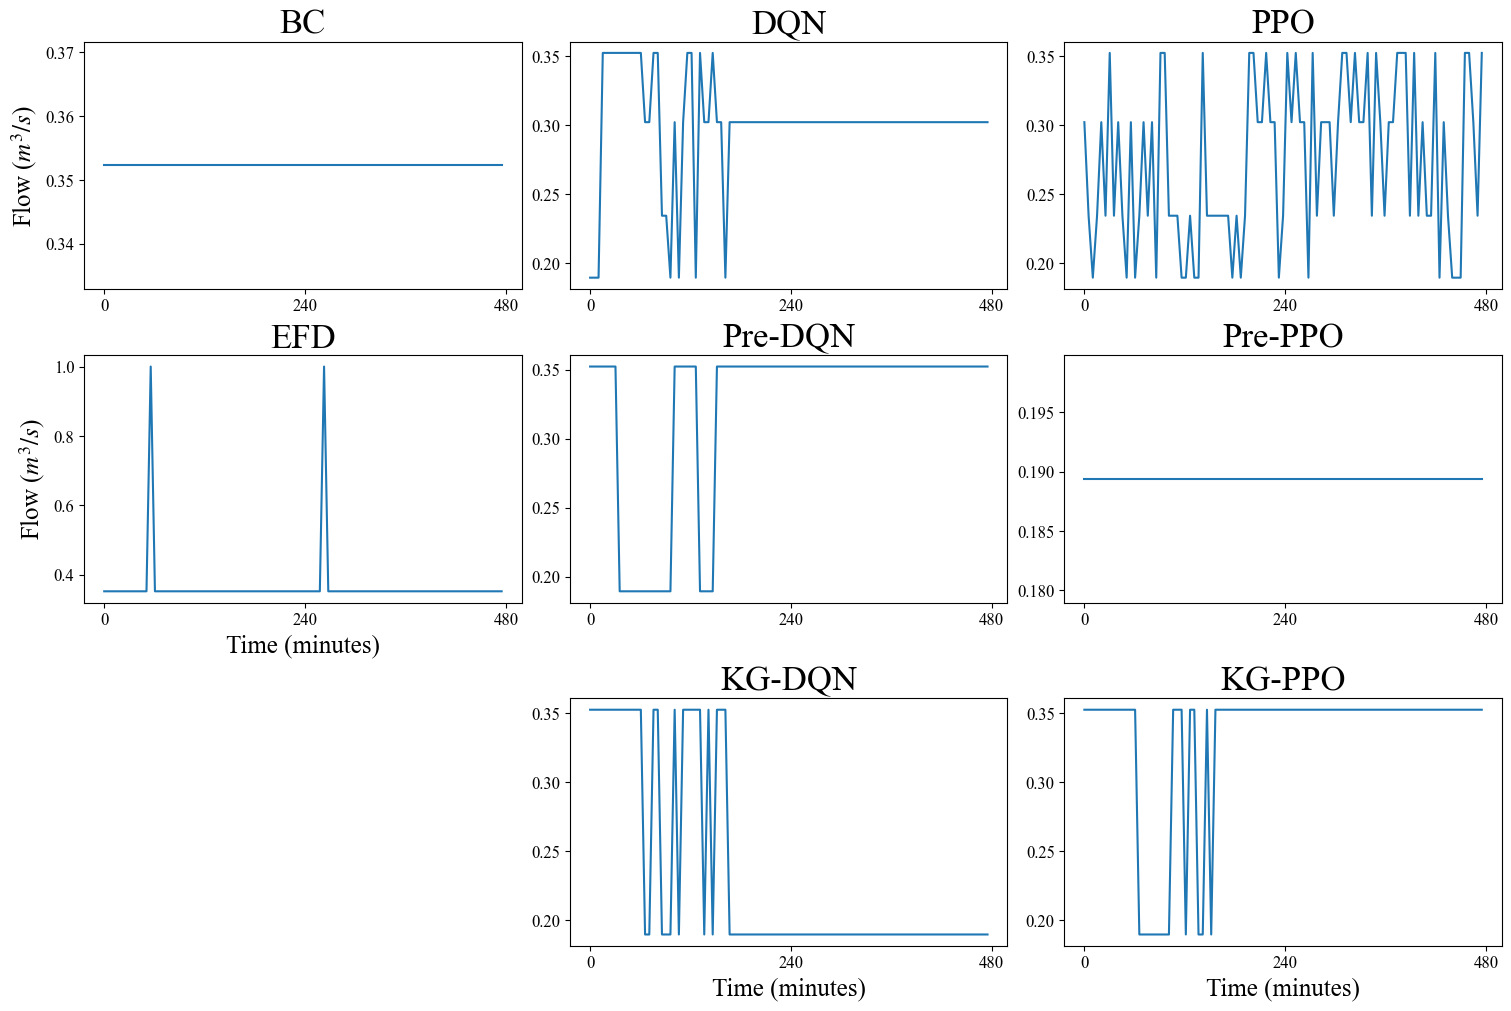

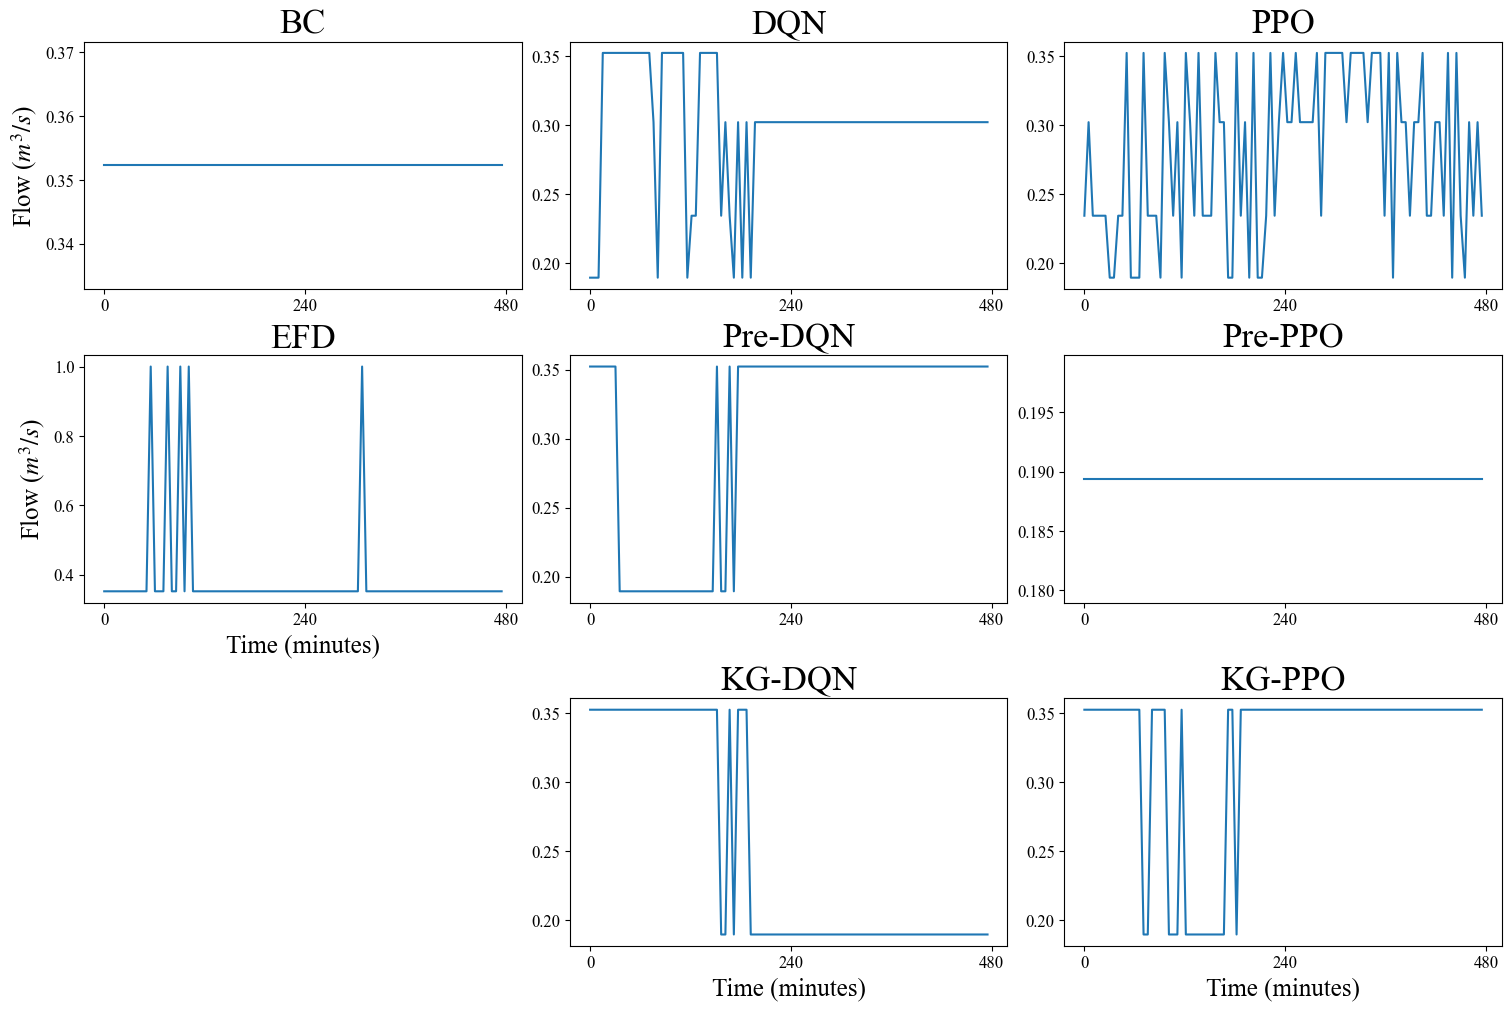

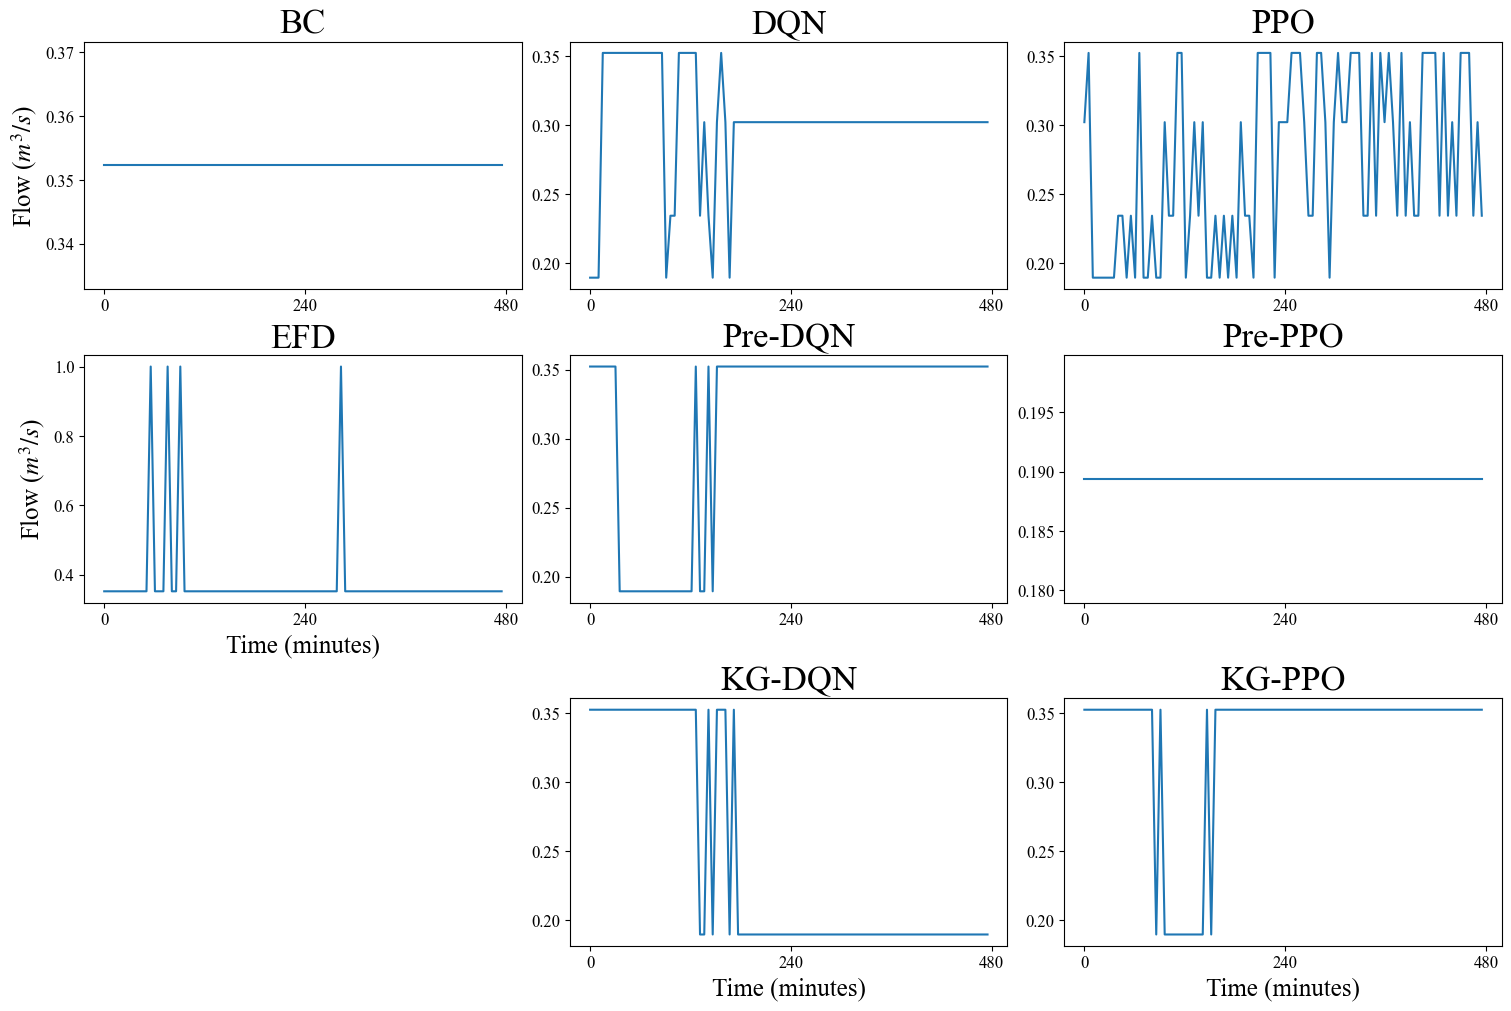

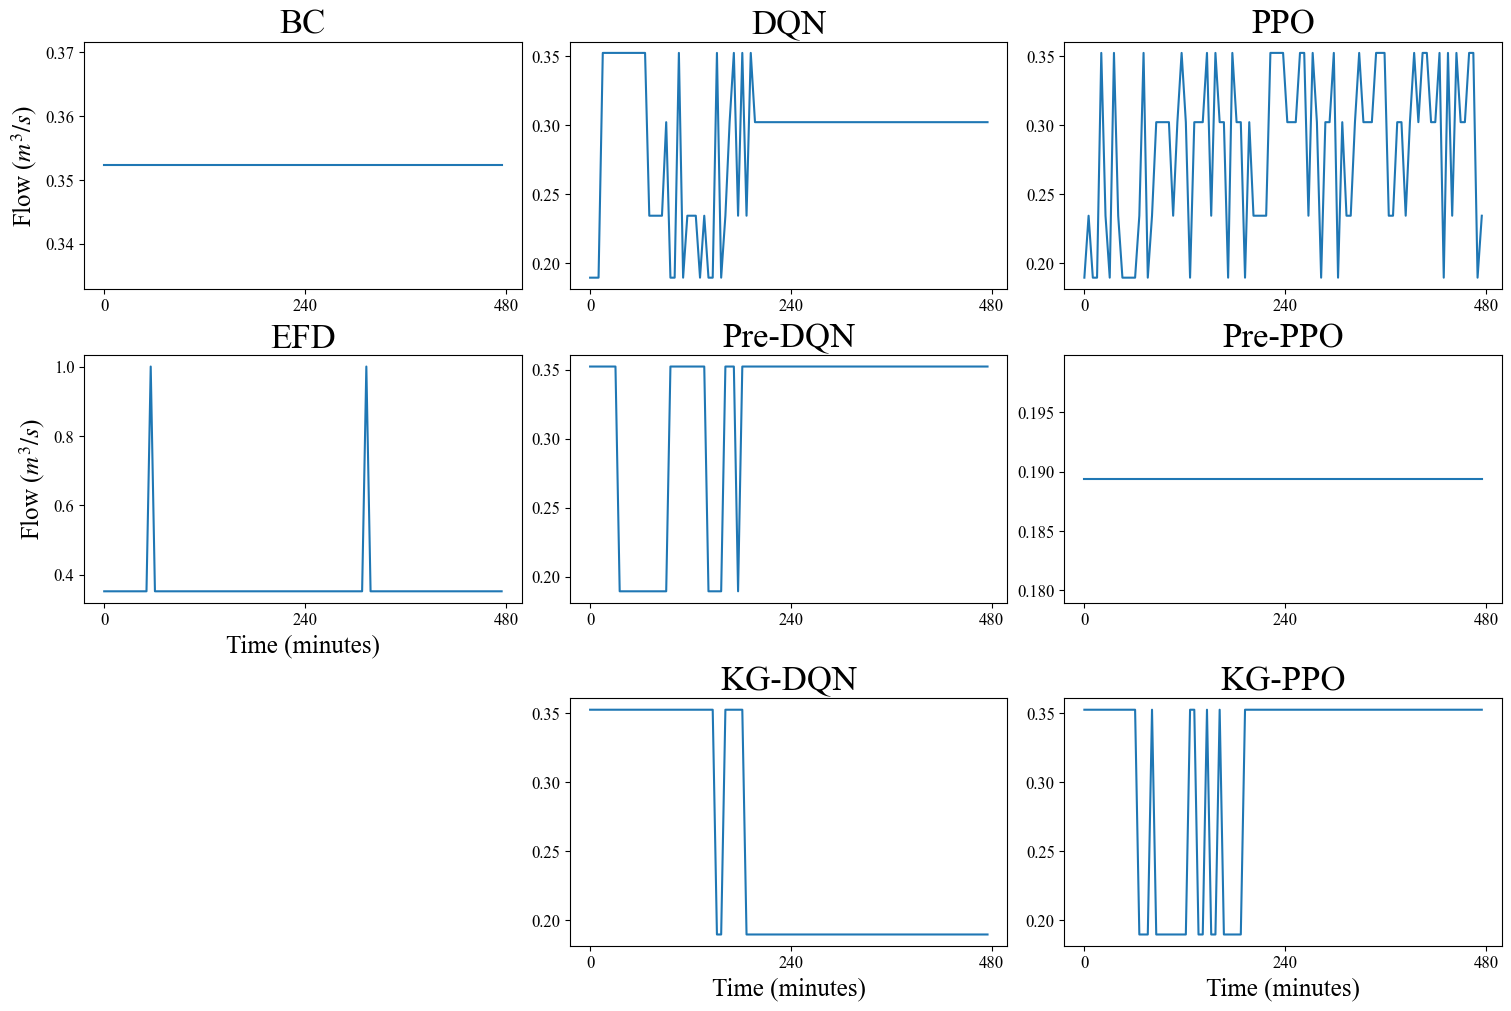

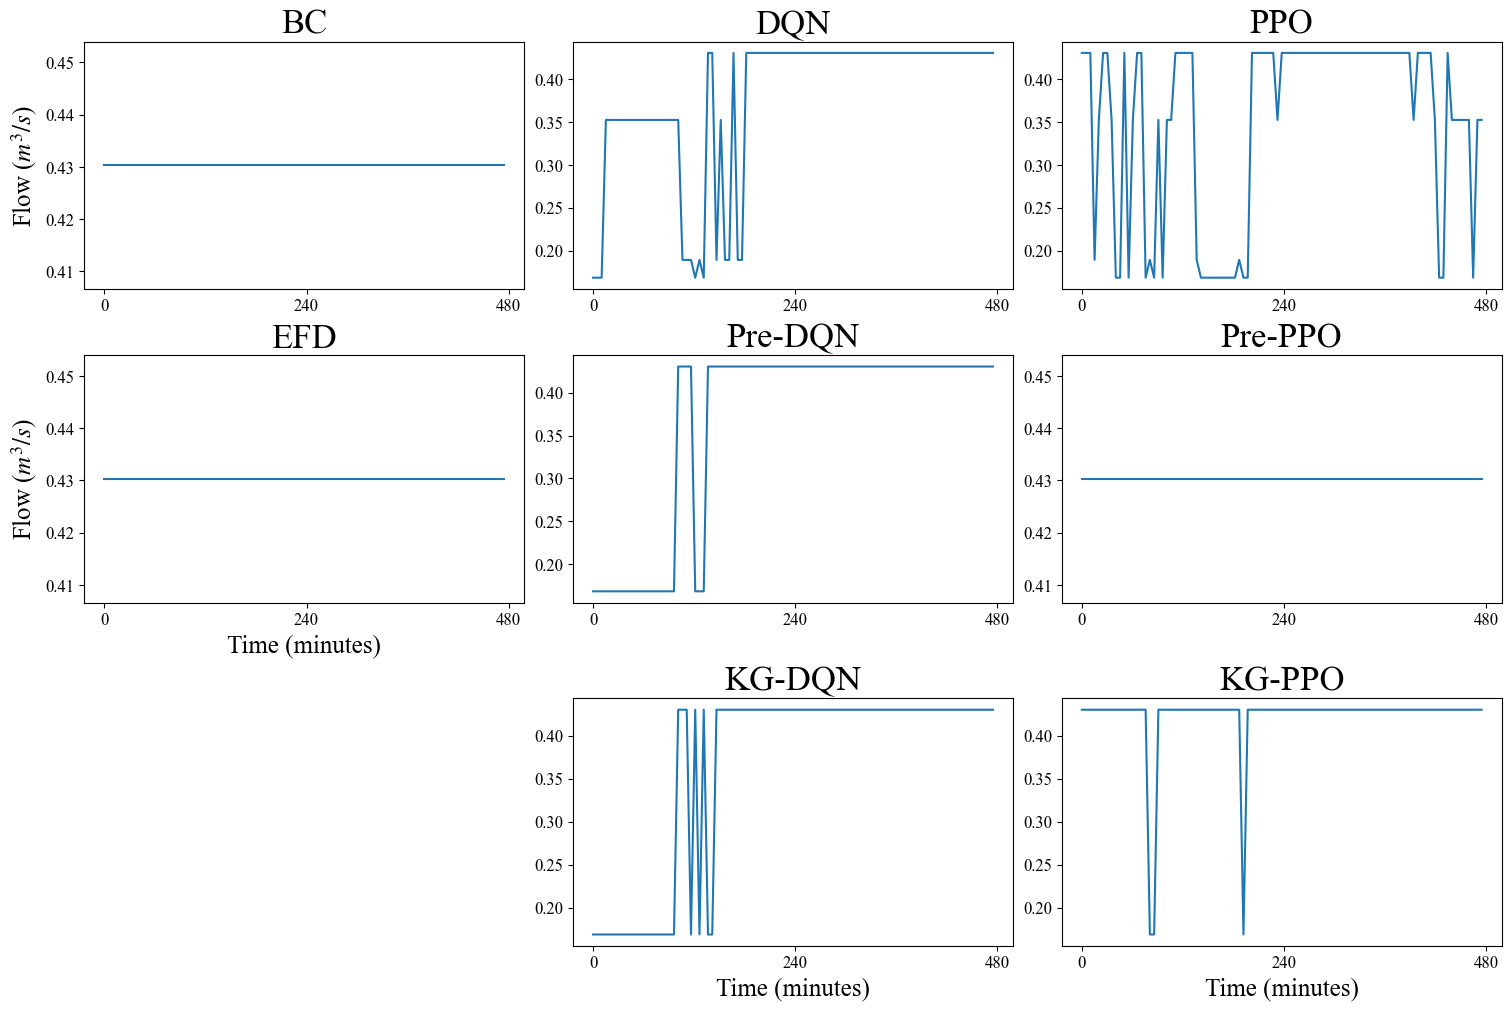

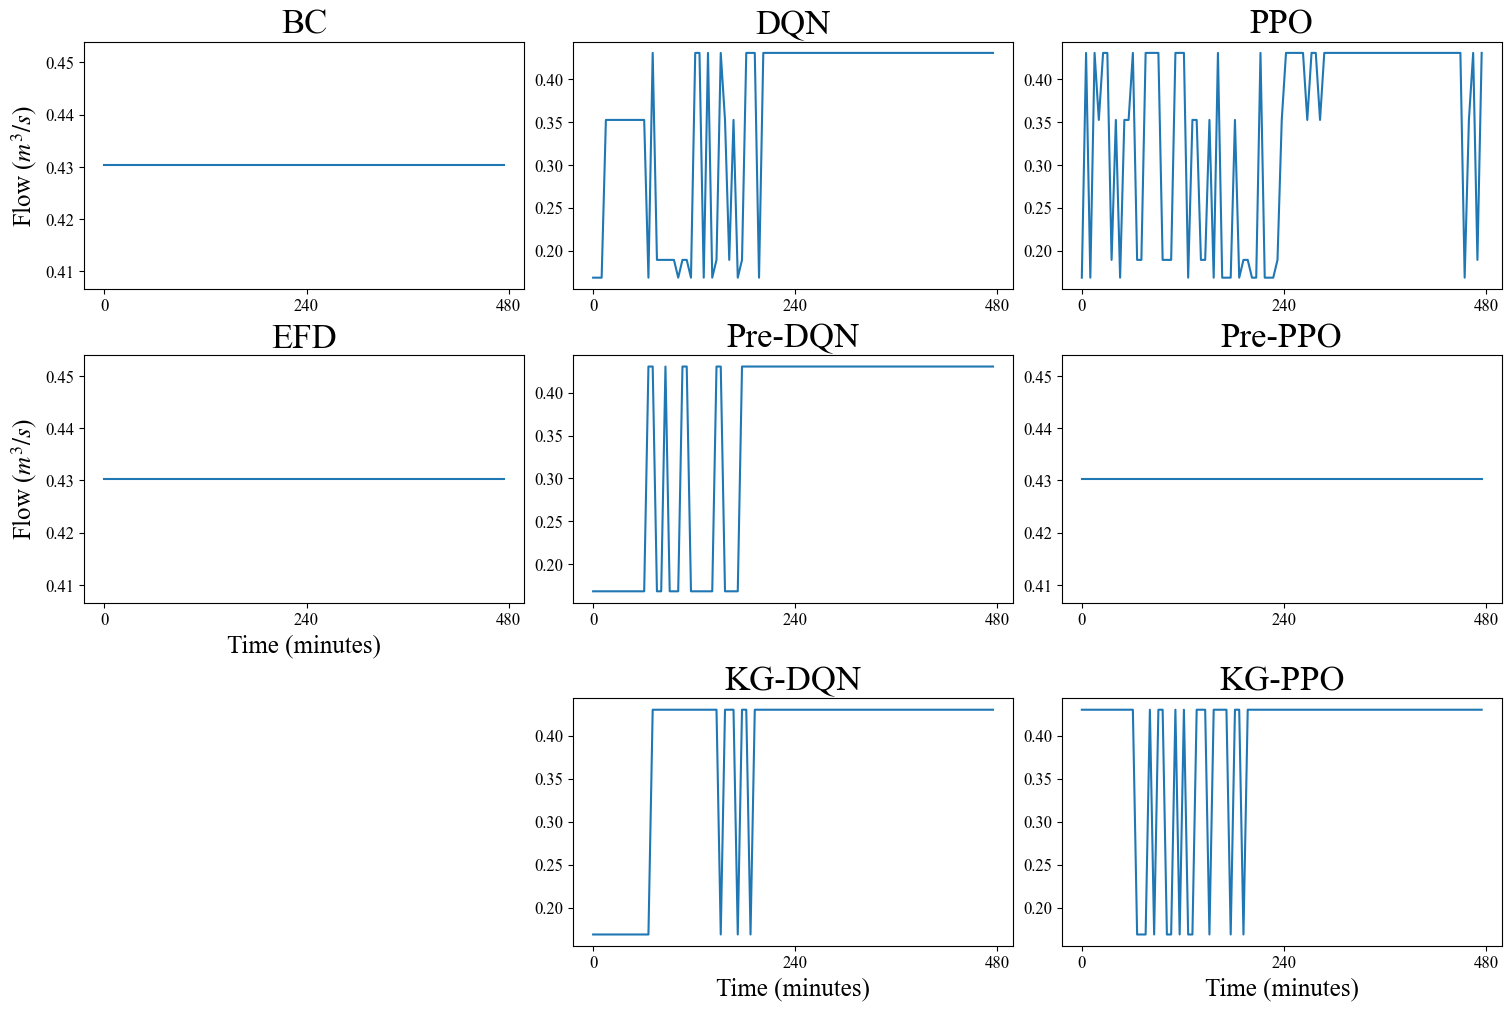

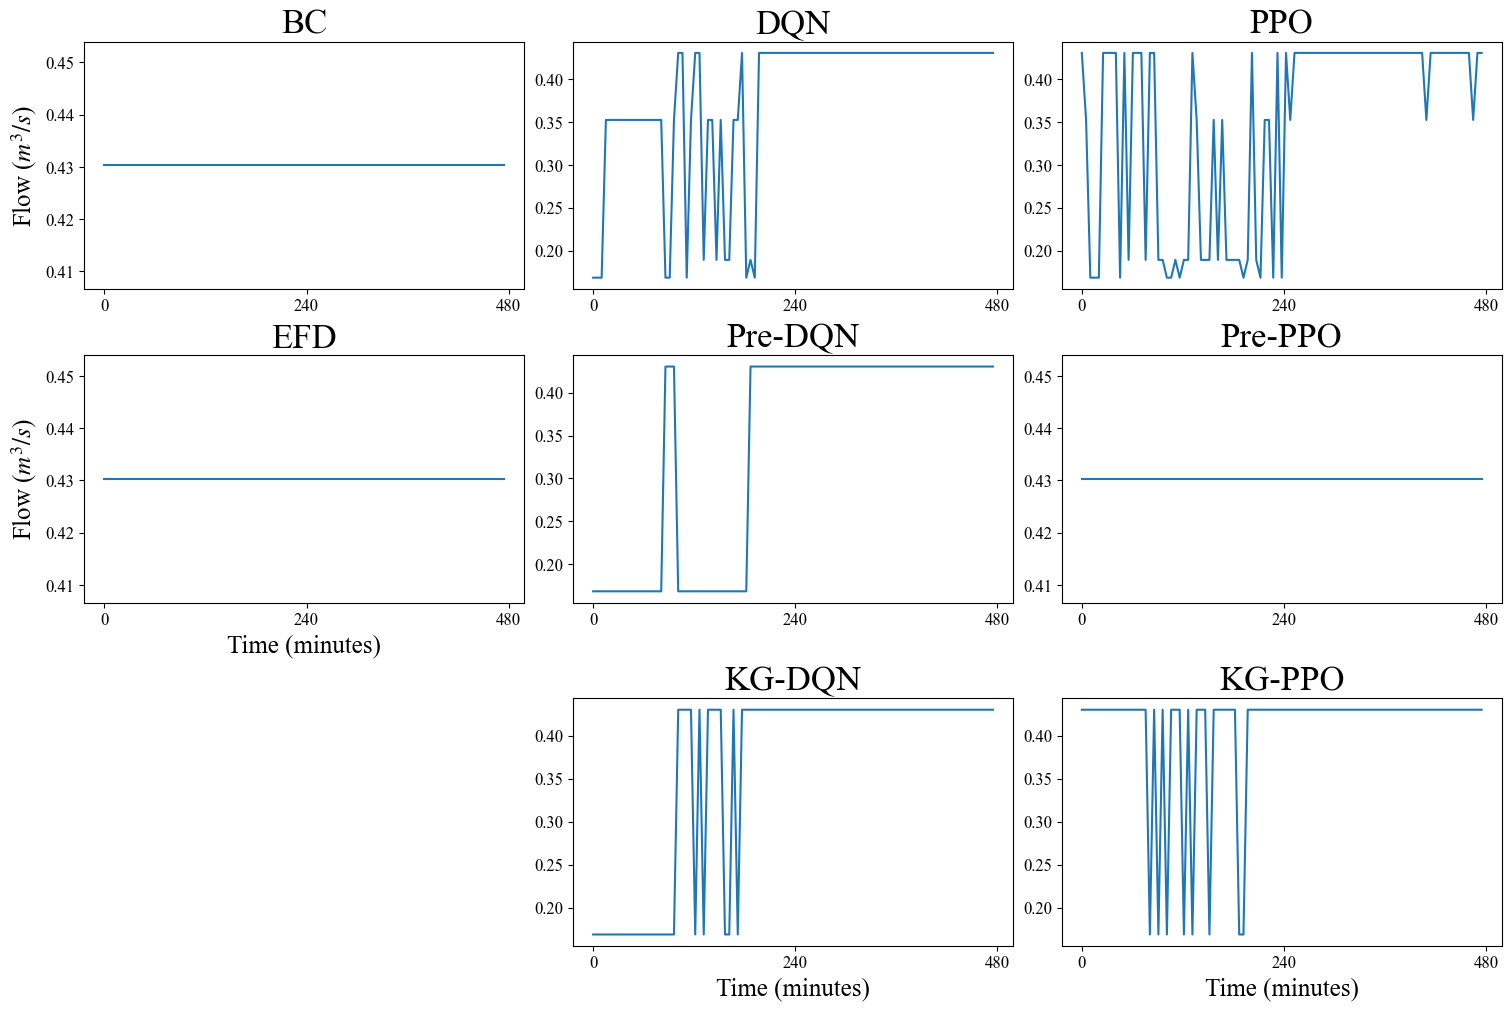

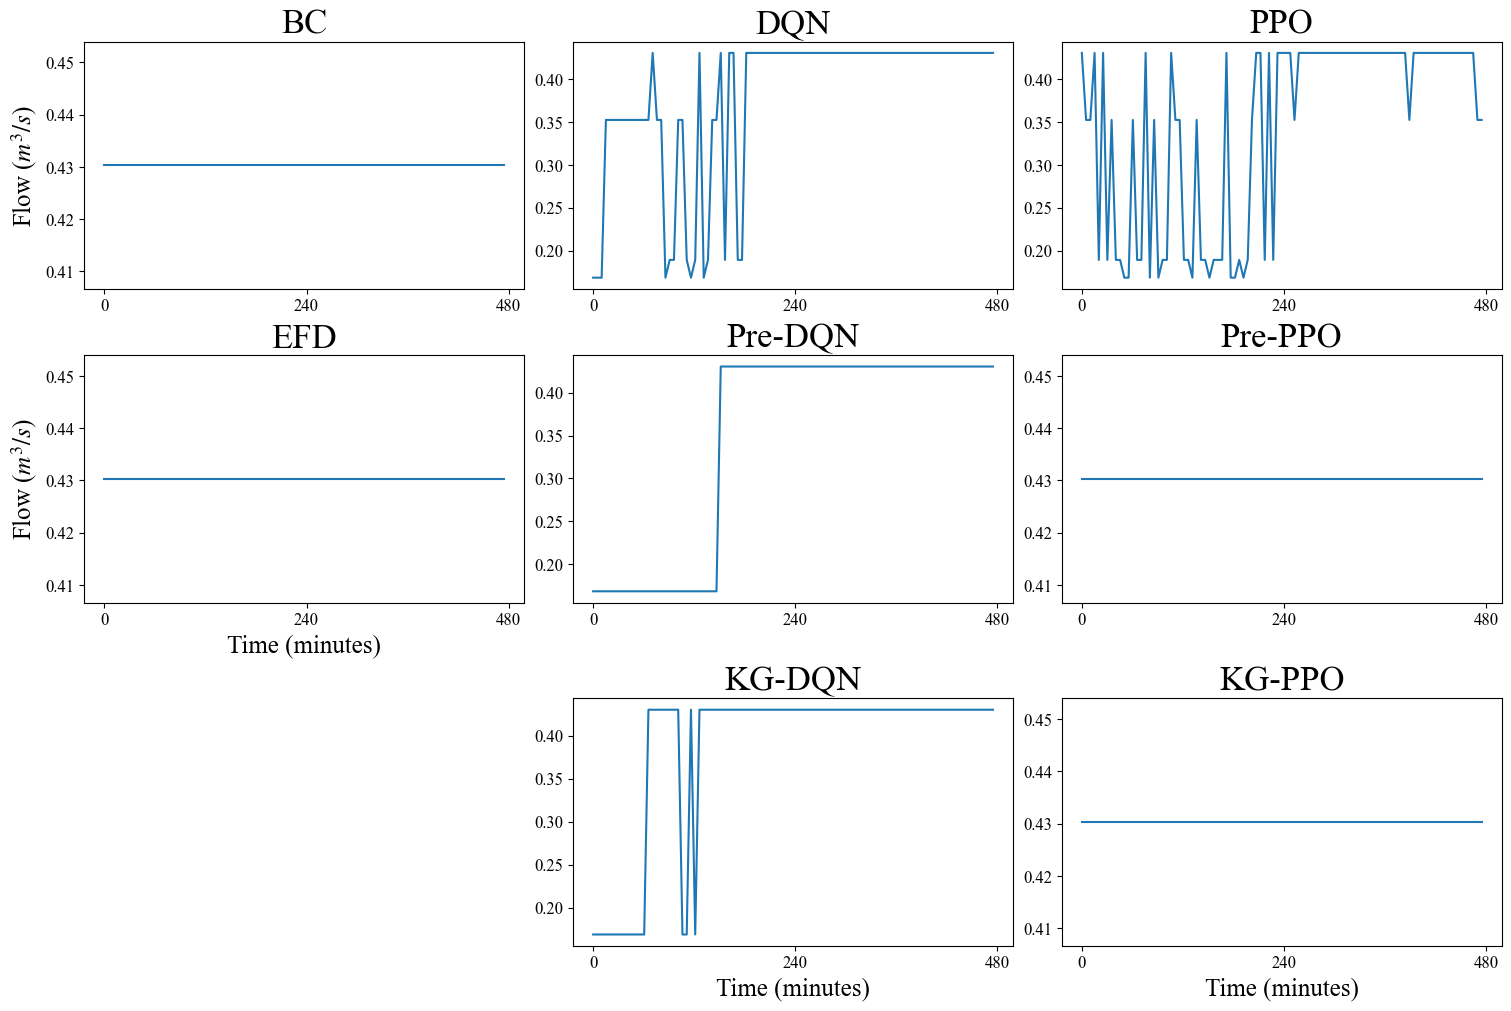

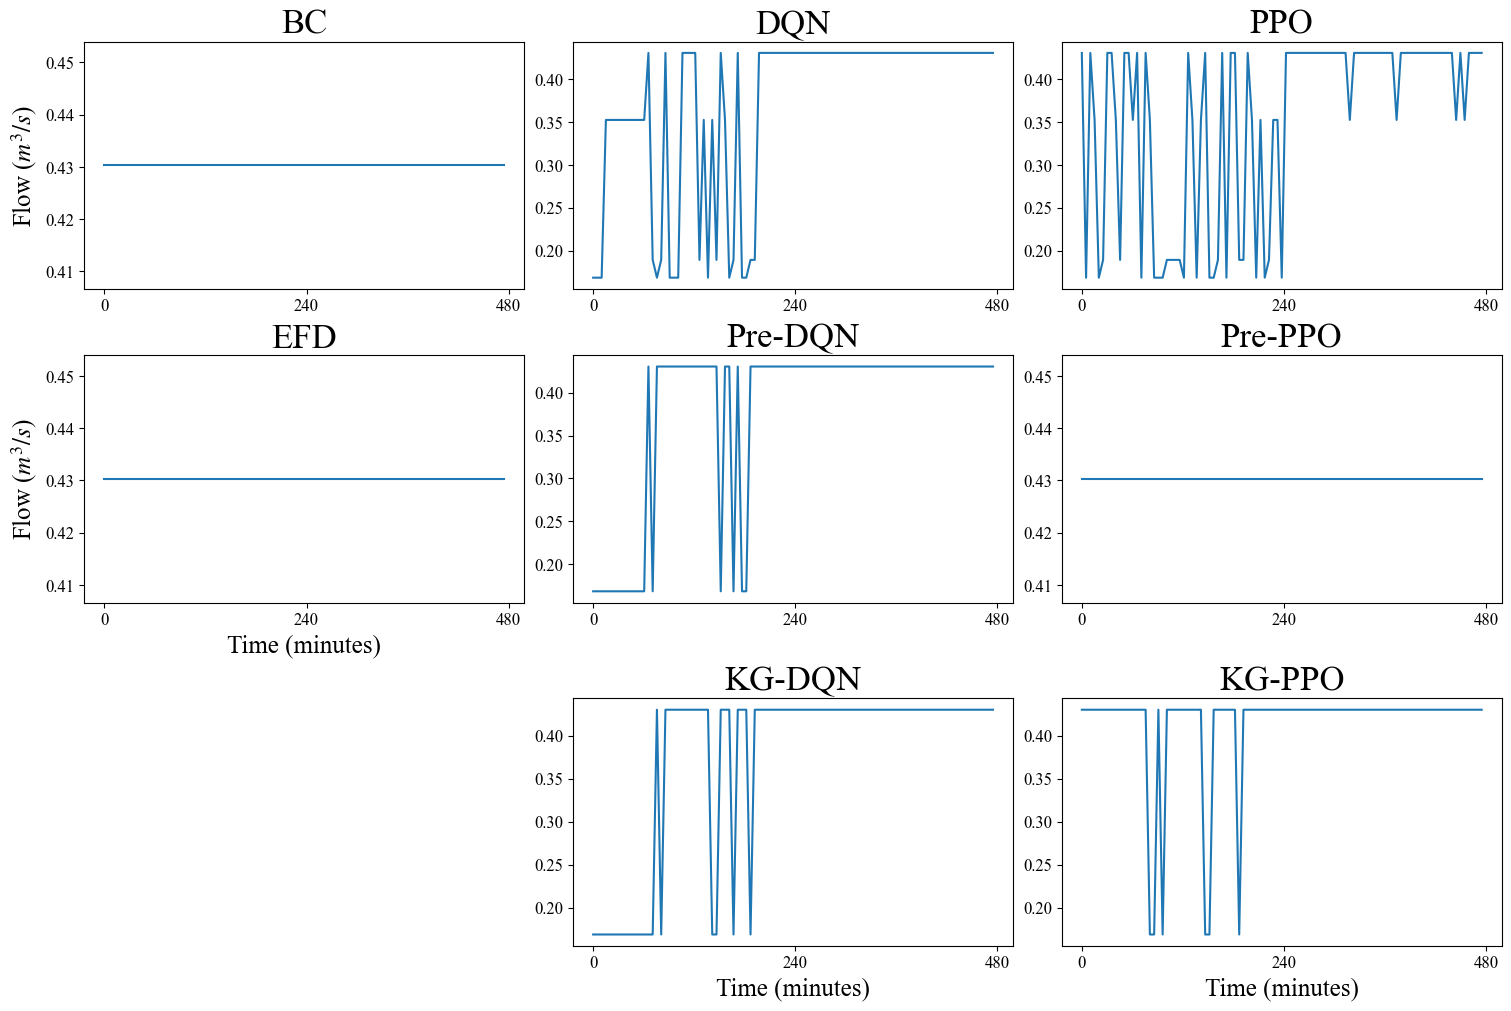

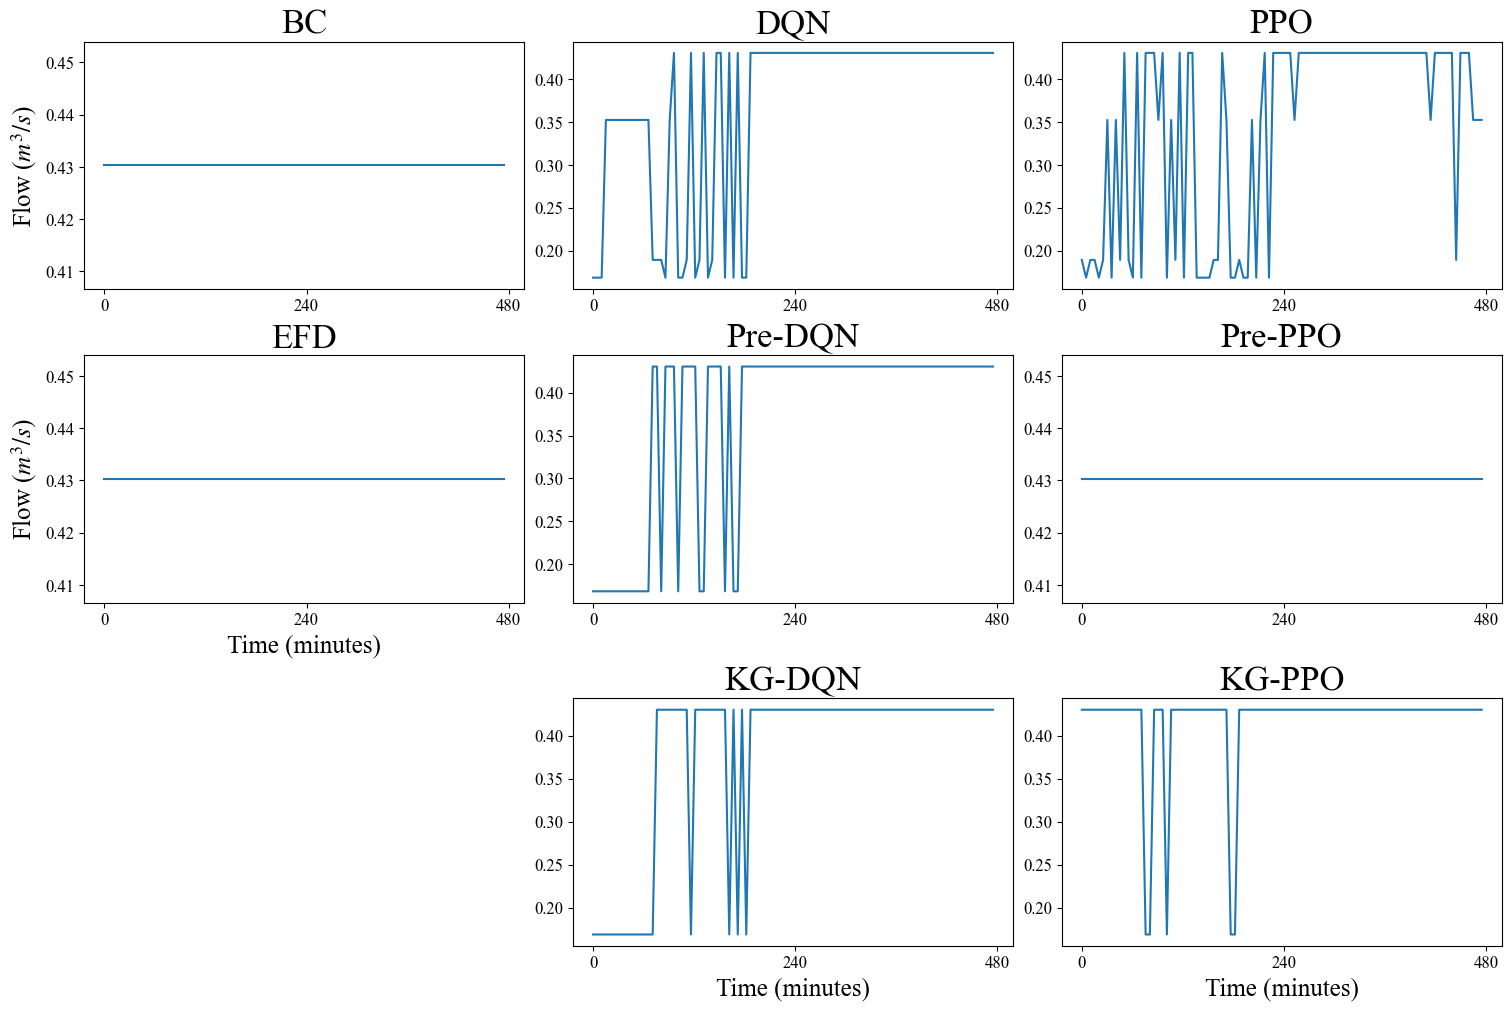

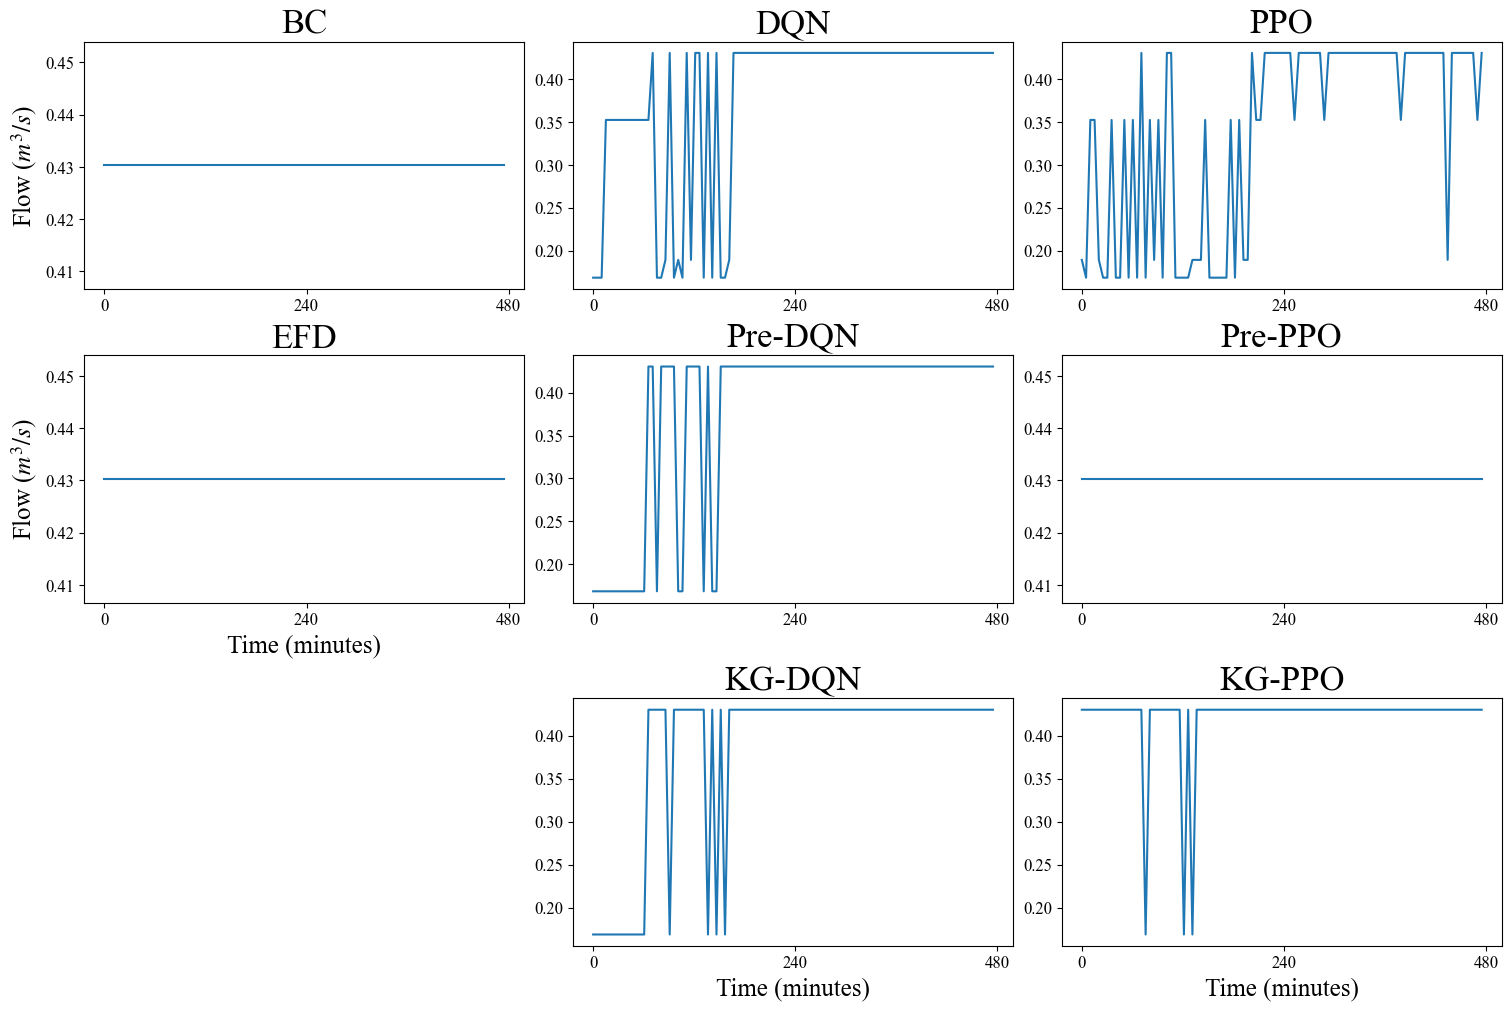

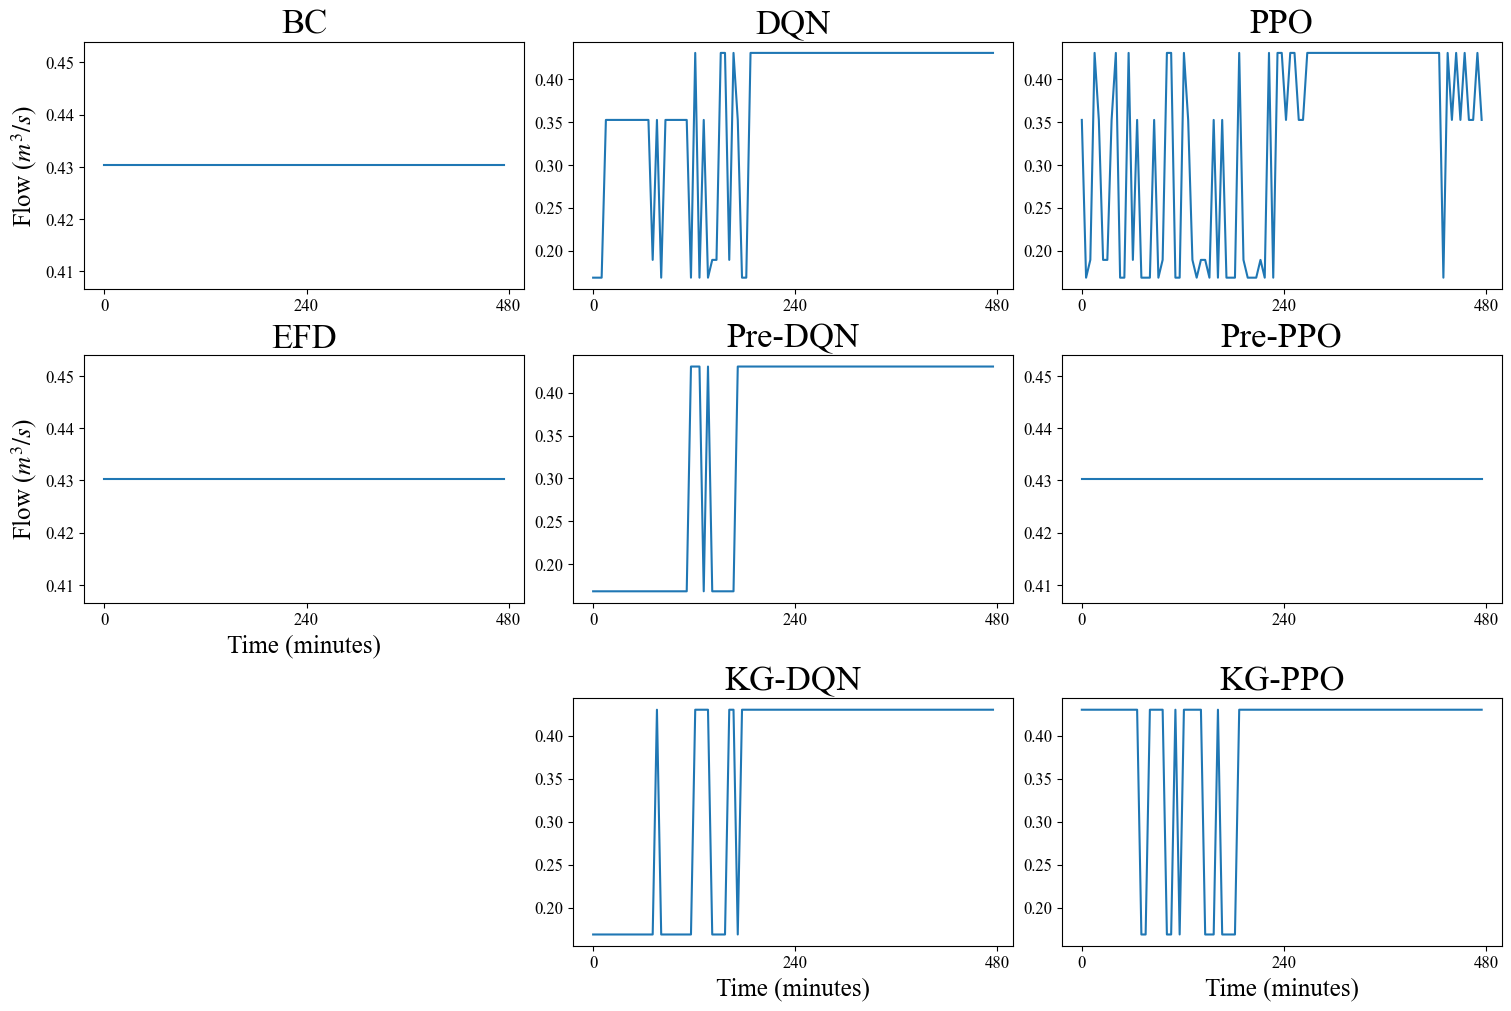

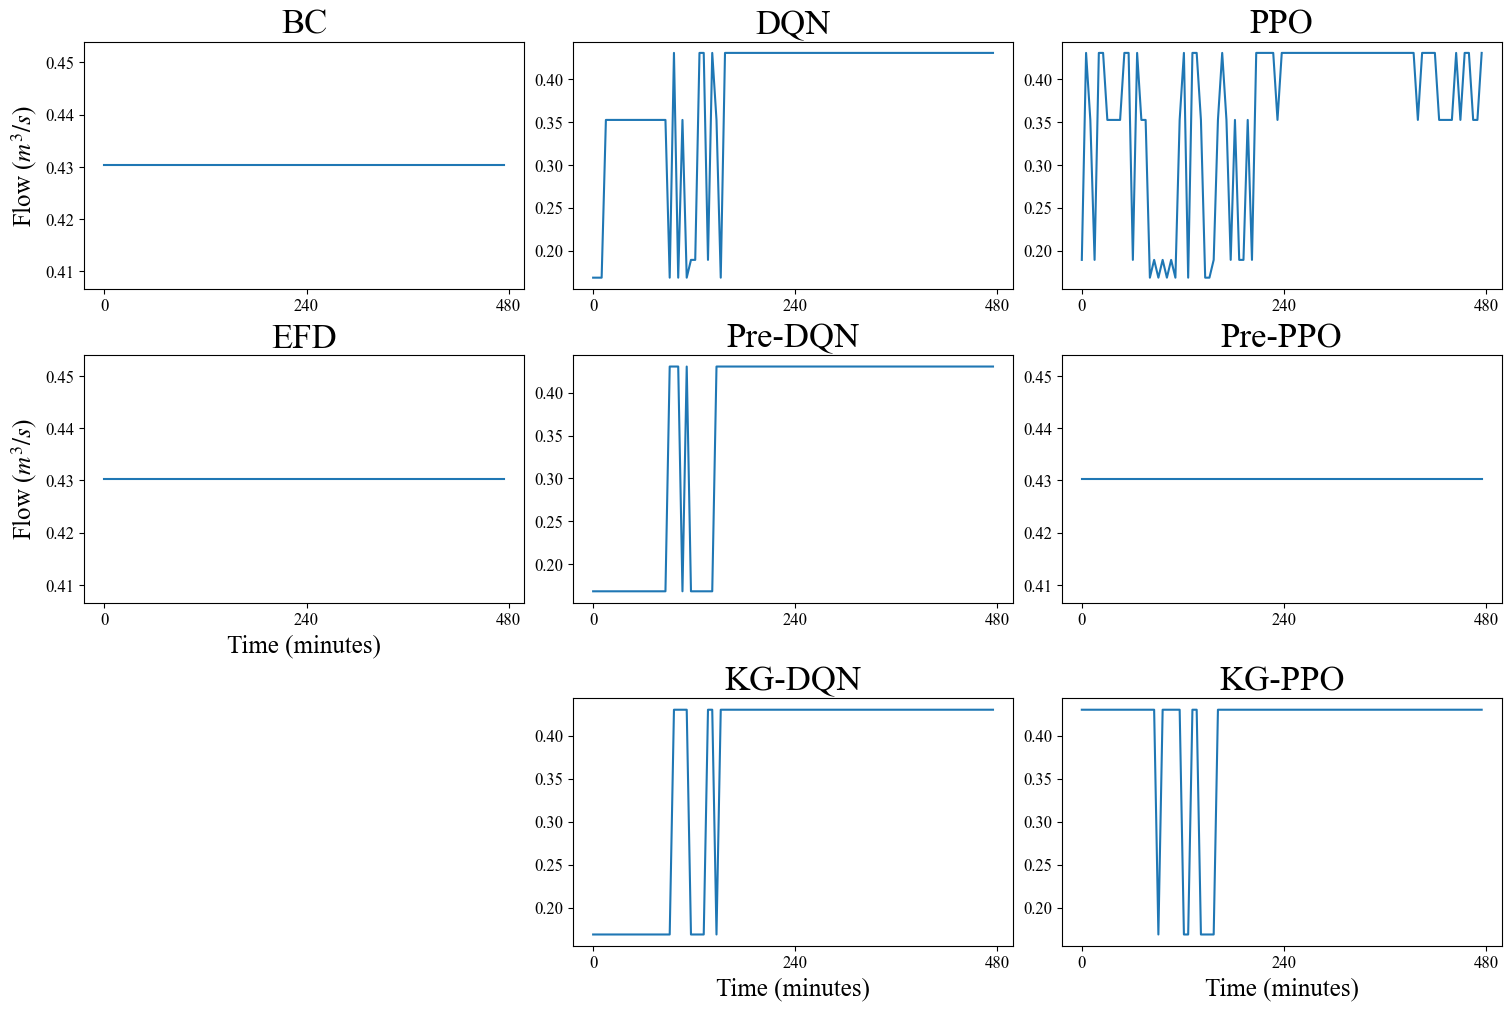

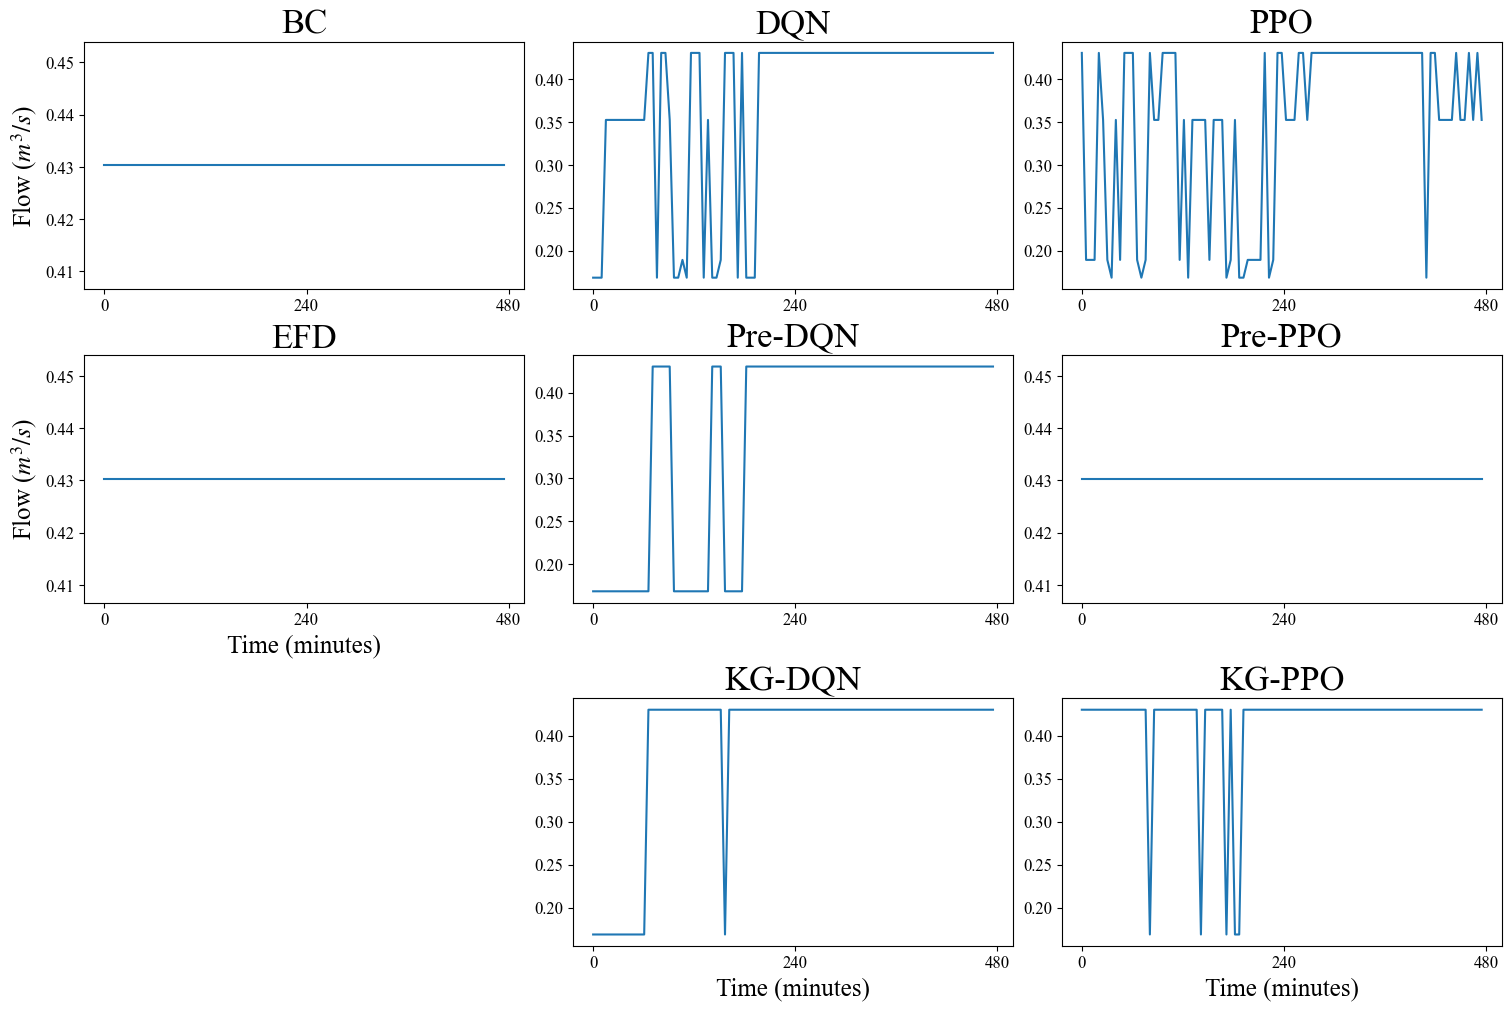

In [14]:
for k in [1,2,3,5]:
    for rid in rainid:
        fig(k,str(rid))

# Depth safety

In [14]:
k=6
i=1
#np.mean(np.array(results_BC['rain'+str(rainid[i])]['state'][1:])[:,k]),
#np.mean(np.array(results_EFD['rain'+str(rainid[i])]['state'][1:])[:,k]),
results = [
    [np.mean(np.array(results_DQN['rain'+str(rainid[i])]['state'][1:])[:,:k]),
    np.mean(np.array(results_DQN_pre['rain'+str(rainid[i])]['state'][1:])[:,:k]),
    np.mean(np.array(results_DQN_KG['rain'+str(rainid[i])]['state'][1:])[:,:k])],
    [np.mean(np.array(results_PPO['rain'+str(rainid[i])]['state'][1:])[:,:k]),
    np.mean(np.array(results_PPO_pre['rain'+str(rainid[i])]['state'][1:])[:,:k]),
    np.mean(np.array(results_PPO_KG['rain'+str(rainid[i])]['state'][1:])[:,:k])]
]

print(results)

[[3.7526158297130765, 3.7421570919895433, 3.759955523480509], [3.7537135116358424, 3.682201647483338, 3.7604262733920586]]


In [ ]:
k=2
i=4
print('BC: ',np.mean(np.array(results_BC['rain'+str(rainid[i])]['state'][1:])[:,k]))
print('EFD: ',np.mean(np.array(results_EFD['rain'+str(rainid[i])]['state'][1:])[:,k]))
print('OPT: ',np.mean(np.array(results_OPT['rain'+str(rainid[i])]['state'][1:])[:,k]))
print('DQN: ',np.mean(np.array(results_DQN['rain'+str(rainid[i])]['state'][1:])[:,k]))
print('PPO: ',np.mean(np.array(results_PPO['rain'+str(rainid[i])]['state'][1:])[:,k]))
print('DQN_pre: ',np.mean(np.array(results_DQN_pre['rain'+str(rainid[i])]['state'][1:])[:,k]))
print('PPO_pre: ',np.mean(np.array(results_PPO_pre['rain'+str(rainid[i])]['state'][1:])[:,k]))
print('DQN_KG: ',np.mean(np.array(results_DQN_KG['rain'+str(rainid[i])]['state'][1:])[:,k]))
print('PPO_KG: ',np.mean(np.array(results_PPO_KG['rain'+str(rainid[i])]['state'][1:])[:,k]))